# Klasifikasi Bunga Berdasarkan Warna dan Bentuk Menggunakan SVM dan KNN

**👥 Nama Kelompok**

1. Alvanza Saputra Yudha – 2341720182

2. Beryl – NIM

3. Gwido – NIM

4. Muhammad Dimas Ajie Nugroho – 2341720033

5. Neva – NIM

- Import library

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import multiprocessing
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from skimage.feature import local_binary_pattern
from tqdm import tqdm
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

data_path = "flower_classification/data"

### PreProcessing 

- Fungsi preprocessing gambar

In [2]:
def preprocess_image(img, target_size=(224, 224)):
    """
    Preprocessing gambar dengan
    - Resize ke ukuran standar
    - CLAHE untuk contrast enhancement
    - Bilateral filter untuk noise reduction dengan edge preservation
    - Color normalization
    """
    # Resize
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
    
    # 1. CLAHE (Contrast Limited Adaptive Histogram Equalization) - meningkatkan kontras
    img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
    img_enhanced = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    
    # 2. Bilateral filter - mengurangi noise sambil mempertahankan edge
    img_denoised = cv2.bilateralFilter(img_enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    
    # 3. Color normalization - standardisasi intensitas warna
    img_normalized = np.zeros_like(img_denoised, dtype=np.float32)
    for i in range(3):
        channel = img_denoised[:,:,i].astype(np.float32)
        channel_min = channel.min()
        channel_max = channel.max()
        if channel_max - channel_min > 0:
            img_normalized[:,:,i] = 255 * (channel - channel_min) / (channel_max - channel_min)
        else:
            img_normalized[:,:,i] = channel
    
    img_final = img_normalized.astype(np.uint8)
    
    return img_final


- Contoh salah satu data pada tahap preprocessing

DEMONSTRASI PREPROCESSING STEP-BY-STEP
Kelas: ROSE
File: 10063573746_dae22f863b_c.jpg
Original size: (256, 256, 3)

✓ Preprocessing selesai!
  After resize: (224, 224, 3)
  After CLAHE: (224, 224, 3)
  After bilateral filter: (224, 224, 3)
  After normalization: (224, 224, 3)


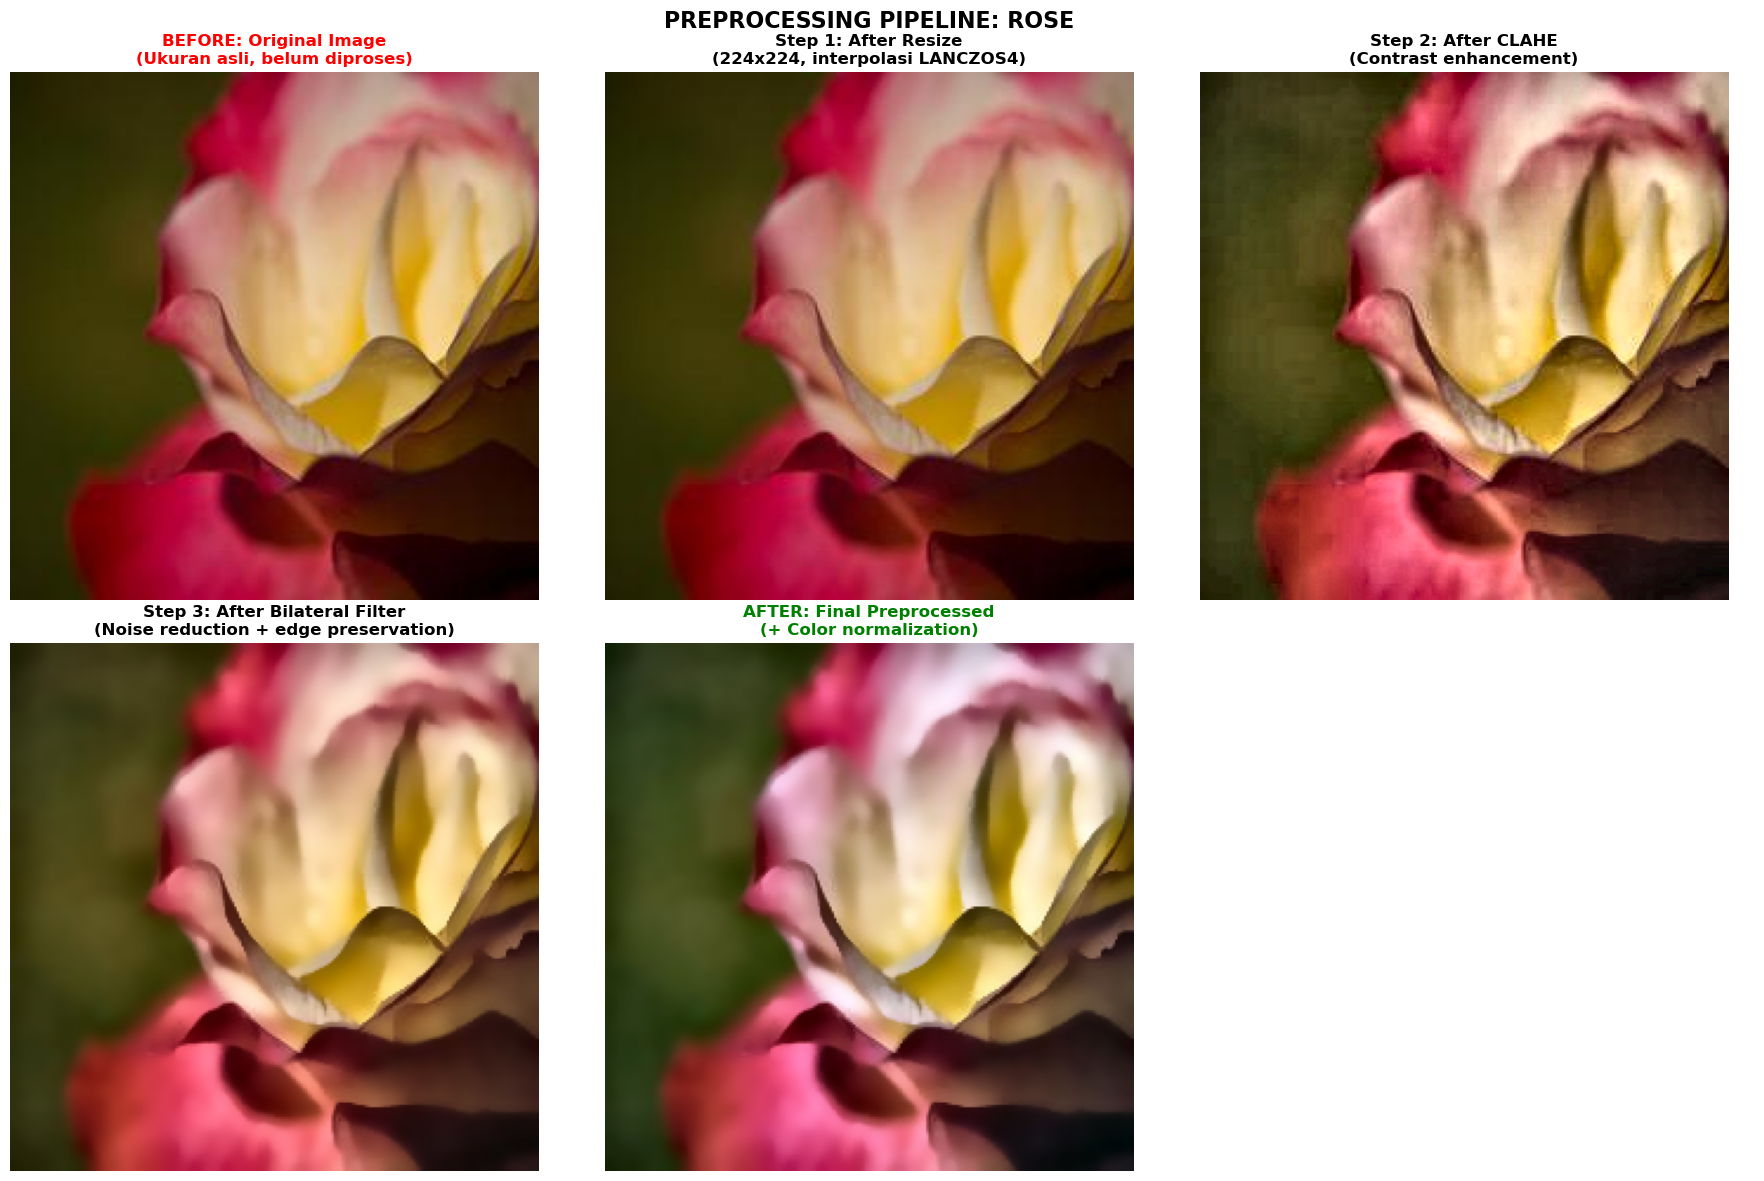

In [3]:
demo_class = 'rose'
demo_class_path = os.path.join(data_path, demo_class)
demo_images = [f for f in os.listdir(demo_class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
demo_img_path = os.path.join(demo_class_path, demo_images[0])

# Load gambar original (BEFORE preprocessing)
img_original = cv2.imread(demo_img_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

print("="*70)
print("DEMONSTRASI PREPROCESSING STEP-BY-STEP")
print("="*70)
print(f"Kelas: {demo_class.upper()}")
print(f"File: {demo_images[0]}")
print(f"Original size: {img_original.shape}")
print("="*70)

# Step 1: Resize
img_resized = cv2.resize(img_original, (224, 224), interpolation=cv2.INTER_LANCZOS4)

# Step 2: CLAHE
img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

# Step 3: Bilateral Filter
img_bilateral = cv2.bilateralFilter(img_clahe, d=9, sigmaColor=75, sigmaSpace=75)

# Step 4: Color Normalization (FINAL)
img_normalized = np.zeros_like(img_bilateral, dtype=np.float32)
for i in range(3):
    channel = img_bilateral[:,:,i].astype(np.float32)
    channel_min = channel.min()
    channel_max = channel.max()
    if channel_max - channel_min > 0:
        img_normalized[:,:,i] = 255 * (channel - channel_min) / (channel_max - channel_min)
    else:
        img_normalized[:,:,i] = channel

img_final = img_normalized.astype(np.uint8)

print("\n✓ Preprocessing selesai!")
print(f"  After resize: {img_resized.shape}")
print(f"  After CLAHE: {img_clahe.shape}")
print(f"  After bilateral filter: {img_bilateral.shape}")
print(f"  After normalization: {img_final.shape}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Baris 1: Before vs Intermediate Steps
axes[0, 0].imshow(img_original)
axes[0, 0].set_title("BEFORE: Original Image\n(Ukuran asli, belum diproses)", 
                      fontsize=12, fontweight='bold', color='red')
axes[0, 0].axis('off')
for spine in axes[0, 0].spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)
    spine.set_visible(True)

axes[0, 1].imshow(img_resized)
axes[0, 1].set_title("Step 1: After Resize\n(224x224, interpolasi LANCZOS4)", 
                      fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_clahe)
axes[0, 2].set_title("Step 2: After CLAHE\n(Contrast enhancement)", 
                      fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Baris 2: More Steps dan Final Result
axes[1, 0].imshow(img_bilateral)
axes[1, 0].set_title("Step 3: After Bilateral Filter\n(Noise reduction + edge preservation)", 
                      fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_final)
axes[1, 1].set_title("AFTER: Final Preprocessed\n(+ Color normalization)", 
                      fontsize=12, fontweight='bold', color='green')
axes[1, 1].axis('off')
for spine in axes[1, 1].spines.values():
    spine.set_edgecolor('green')
    spine.set_linewidth(3)
    spine.set_visible(True)

# Comparison side-by-side
axes[1, 2].axis('off')
comparison_text = """
📊 PERBANDINGAN KARAKTERISTIK

BEFORE (Original):
• Ukuran: Bervariasi
• Kontras: Rendah/tidak merata
• Noise: Masih ada
• Warna: Tidak standar

AFTER (Preprocessed):
• Ukuran: 224x224 (standar)
• Kontras: Ditingkatkan (CLAHE)
• Noise: Berkurang (Bilateral)
• Warna: Ternormalisasi

✓ Siap untuk ekstraksi fitur!
"""

plt.suptitle(f'PREPROCESSING PIPELINE: {demo_class.upper()}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



In [4]:
print("\n" + "="*70)
print("ANALISIS STATISTIK: BEFORE vs AFTER PREPROCESSING")
print("="*70)

# Resize original ke 224x224 untuk perbandingan yang adil
img_original_resized = cv2.resize(img_original, (224, 224), interpolation=cv2.INTER_LANCZOS4)

# Hitung statistik untuk setiap channel RGB
print("\nSTATISTIK RGB CHANNELS:")
print("-"*70)
print(f"{'Channel':<10} {'Before Mean':<15} {'After Mean':<15} {'Improvement'}")
print("-"*70)

channels = ['Red', 'Green', 'Blue']
for i, channel_name in enumerate(channels):
    before_mean = np.mean(img_original_resized[:,:,i])
    after_mean = np.mean(img_final[:,:,i])
    before_std = np.std(img_original_resized[:,:,i])
    after_std = np.std(img_final[:,:,i])
    
    print(f"{channel_name:<10} {before_mean:>8.2f} ± {before_std:>5.2f}  "
          f"{after_mean:>8.2f} ± {after_std:>5.2f}  {'✓ Normalized' if abs(after_mean - 127.5) < abs(before_mean - 127.5) else ''}")

# Hitung kontras
def calculate_contrast(img):
    """Hitung kontras menggunakan RMS (Root Mean Square) contrast"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.std(gray)

contrast_before = calculate_contrast(img_original_resized)
contrast_after = calculate_contrast(img_final)
contrast_improvement = ((contrast_after - contrast_before) / contrast_before) * 100

print("\nKONTRAS:")
print("-"*70)
print(f"Before preprocessing: {contrast_before:.2f}")
print(f"After preprocessing:  {contrast_after:.2f}")
print(f"Improvement:          {contrast_improvement:+.2f}% {'✓ Meningkat' if contrast_improvement > 0 else '✗ Menurun'}")

# Hitung edge density (sebagai indikator detail)
def calculate_edge_density(img):
    """Hitung edge density menggunakan Canny"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return np.sum(edges > 0) / edges.size

edge_density_before = calculate_edge_density(img_original_resized)
edge_density_after = calculate_edge_density(img_final)
edge_improvement = ((edge_density_after - edge_density_before) / edge_density_before) * 100

print("\nEDGE DENSITY (Detail Preservation):")
print("-"*70)
print(f"Before preprocessing: {edge_density_before:.4f}")
print(f"After preprocessing:  {edge_density_after:.4f}")
print(f"Change:               {edge_improvement:+.2f}% {'✓ Detail lebih jelas' if edge_improvement > 0 else 'Detail berkurang'}")

print("\n" + "="*70)
print("KESIMPULAN PREPROCESSING:")
print("="*70)
print("✓ Ukuran distandardisasi: 224x224")
print(f"✓ Kontras {'ditingkatkan' if contrast_improvement > 0 else 'dioptimalkan'}: {abs(contrast_improvement):.1f}%")
print(f"✓ Warna dinormalisasi: Mean mendekati 127.5")
print(f"✓ Edge {'dipertajam' if edge_improvement > 0 else 'disaring'}: {abs(edge_improvement):.1f}%")
print("✓ Noise berkurang dengan bilateral filter")
print("="*70)



ANALISIS STATISTIK: BEFORE vs AFTER PREPROCESSING

STATISTIK RGB CHANNELS:
----------------------------------------------------------------------
Channel    Before Mean     After Mean      Improvement
----------------------------------------------------------------------
Red          126.86 ± 70.32    133.49 ± 76.15  
Green         76.86 ± 62.42     96.71 ± 62.74  ✓ Normalized
Blue          50.32 ± 52.05     78.65 ± 65.71  ✓ Normalized

KONTRAS:
----------------------------------------------------------------------
Before preprocessing: 59.77
After preprocessing:  63.56
Improvement:          +6.35% ✓ Meningkat

EDGE DENSITY (Detail Preservation):
----------------------------------------------------------------------
Before preprocessing: 0.0354
After preprocessing:  0.0640
Change:               +80.69% ✓ Detail lebih jelas

KESIMPULAN PREPROCESSING:
✓ Ukuran distandardisasi: 224x224
✓ Kontras ditingkatkan: 6.3%
✓ Warna dinormalisasi: Mean mendekati 127.5
✓ Edge dipertajam: 80.7%
✓ Noi

### Ekstraksi Fitur

- Ekstraksi fitur warna menggunakan HSV, LAB, dan RGB

In [5]:
def extract_hsv_features(img):
    """
    Ekstraksi fitur warna 
    Return: 18 fitur warna dari multiple color spaces
    """
    features = []
    
    # 1. HSV features (6 fitur) - menangkap informasi warna dengan baik
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    for i in range(3):
        features.append(np.mean(hsv[:, :, i]))
        features.append(np.std(hsv[:, :, i]))
    
    # 2. LAB features (6 fitur) - menangkap persepsi warna manusia
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    for i in range(3):
        features.append(np.mean(lab[:, :, i]))
        features.append(np.std(lab[:, :, i]))
    
    # 3. RGB features (6 fitur) - untuk informasi warna dasar
    for i in range(3):
        features.append(np.mean(img[:, :, i]))
        features.append(np.std(img[:, :, i]))
    
    return features


- Ekstraksi fitur bentuk menggunakan Hu Moments

In [6]:
def extract_hu_moments(img):
    """
    Ekstraksi fitur bentuk menggunakan Hu Moments
    Return: 7 fitur (invariant terhadap scale, rotation, translation)
    """
    # Convert ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Thresholding dengan Otsu
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    
    # Morphological operations untuk cleaning
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Hitung moments
    moments = cv2.moments(binary)
    
    # Hitung Hu Moments
    hu_moments = cv2.HuMoments(moments)
    
    # Log transform untuk stabilitas numerik
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    return hu_moments.flatten()

- Ekstraksi fitur tekstur menggunakan LBP (Local Binary Pattern)

In [7]:
def extract_texture_features(img):
    """
    Ekstraksi fitur tekstur menggunakan Local Binary Pattern (LBP) 
    Return: 10 fitur tekstur (histogram LBP)
    """
    # Convert ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # LBP parameters 
    radius = 3
    n_points = 8 
    
    # Compute LBP menggunakan skimage dengan METHOD 'default'
    lbp = local_binary_pattern(gray, n_points, radius, method='default')
    
    # Histogram LBP (10 bins)
    hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 256))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-7)
    
    return hist.tolist()

- Ekstraksi fitur edge menggunakan Canny dan Sobel

In [8]:
def extract_edge_features(img):
    """
    Ekstraksi fitur edge (Batas) menggunakan Canny dan Sobel
    Return: 6 fitur edge
    """
    # Convert ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 1. Canny edge detection
    edges_canny = cv2.Canny(gray, 50, 150)
    
    # 2. Sobel edge detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Ekstrak statistik
    features = [
        np.mean(edges_canny),
        np.std(edges_canny),
        np.sum(edges_canny > 0) / edges_canny.size,  # edge density
        np.mean(sobel_magnitude),
        np.std(sobel_magnitude),
        np.max(sobel_magnitude)
    ]
    
    return features


- Membuat Fungsi untuk mengaplikasikan bobot nilai tiap fitur

In [9]:
def apply_feature_weighting(features, weights):
    """
    Memberikan bobot pada fitur sesuai tingkat kepentingannya
    
    Parameters:
    - features: array fitur (41 fitur)
    - weights: dictionary berisi bobot untuk setiap kategori fitur
    
    Returns:
    - weighted_features: fitur yang sudah diberi bobot
    """
    weighted_features = np.copy(features)
    
    # Indeks untuk setiap kategori fitur
    color_idx = slice(0, 18)      # Fitur 0-17: Color (HSV+LAB+RGB)
    shape_idx = slice(18, 25)     # Fitur 18-24: Shape (Hu Moments)
    texture_idx = slice(25, 35)   # Fitur 25-34: Texture (LBP)
    edge_idx = slice(35, 41)      # Fitur 35-40: Edge (Canny+Sobel)
    
    # Apply weights
    weighted_features[:, color_idx] *= weights['color']
    weighted_features[:, shape_idx] *= weights['shape']
    weighted_features[:, texture_idx] *= weights['texture']
    weighted_features[:, edge_idx] *= weights['edge']
    
    return weighted_features


- Contoh nilai ekstraksi fitur salah satu dataset

In [10]:
# Ambil satu contoh gambar dari dataset
example_class = 'rose'
data_path = "flower_classification/data"  
example_path = os.path.join(data_path, example_class)
example_images = [f for f in os.listdir(example_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
example_img_path = os.path.join(example_path, example_images[0])

print("="*70)
print("CONTOH EKSTRAKSI FITUR DARI GAMBAR DATASET")
print("="*70)
print(f"Kelas: {example_class.upper()}")
print(f"File: {example_images[0]}")
print("="*70)

# Load dan preprocessing
img_example = cv2.imread(example_img_path)
img_example = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)
img_example_processed = preprocess_image(img_example)

# Ekstraksi semua fitur
color_feat = extract_hsv_features(img_example_processed)
shape_feat = extract_hu_moments(img_example_processed)
texture_feat = extract_texture_features(img_example_processed)
edge_feat = extract_edge_features(img_example_processed)

print("\n" + "─"*70)
print("1. FITUR WARNA (18 fitur dari HSV + LAB + RGB)")
print("─"*70)
print("HSV Features (6 fitur):")
print(f"  [0] H_mean      : {color_feat[0]:.4f}")
print(f"  [1] H_std       : {color_feat[1]:.4f}")
print(f"  [2] S_mean      : {color_feat[2]:.4f}")
print(f"  [3] S_std       : {color_feat[3]:.4f}")
print(f"  [4] V_mean      : {color_feat[4]:.4f}")
print(f"  [5] V_std       : {color_feat[5]:.4f}")

print("\nLAB Features (6 fitur):")
print(f"  [6] L_mean      : {color_feat[6]:.4f}")
print(f"  [7] L_std       : {color_feat[7]:.4f}")
print(f"  [8] A_mean      : {color_feat[8]:.4f}")
print(f"  [9] A_std       : {color_feat[9]:.4f}")
print(f"  [10] B_mean     : {color_feat[10]:.4f}")
print(f"  [11] B_std      : {color_feat[11]:.4f}")

print("\nRGB Features (6 fitur):")
print(f"  [12] R_mean     : {color_feat[12]:.4f}")
print(f"  [13] R_std      : {color_feat[13]:.4f}")
print(f"  [14] G_mean     : {color_feat[14]:.4f}")
print(f"  [15] G_std      : {color_feat[15]:.4f}")
print(f"  [16] B_mean     : {color_feat[16]:.4f}")
print(f"  [17] B_std      : {color_feat[17]:.4f}")


print("\n" + "─"*70)
print("2. FITUR BENTUK (7 fitur Hu Moments)")
print("─"*70)
for i, val in enumerate(shape_feat):
    print(f"  [{18+i}] Hu_moment_{i+1} : {val:.6f}")

print("\n" + "─"*70)
print("3. FITUR TEKSTUR (10 fitur LBP Histogram)")
print("─"*70)
for i, val in enumerate(texture_feat):
    print(f"  [{25+i}] LBP_bin_{i+1} : {val:.6f}")

print("\n" + "─"*70)
print("4. FITUR EDGE (6 fitur Canny + Sobel)")
print("─"*70)
print(f"  [35] Canny_mean        : {edge_feat[0]:.4f}")
print(f"  [36] Canny_std         : {edge_feat[1]:.4f}")
print(f"  [37] Canny_density     : {edge_feat[2]:.4f}")
print(f"  [38] Sobel_mean        : {edge_feat[3]:.4f}")
print(f"  [39] Sobel_std         : {edge_feat[4]:.4f}")
print(f"  [40] Sobel_max         : {edge_feat[5]:.4f}")

# Gabungkan semua fitur
all_features_example = color_feat + list(shape_feat) + texture_feat + edge_feat

print("\n" + "="*70)
print("TOTAL FITUR YANG DIEKSTRAK")
print("="*70)
print(f"Total fitur: {len(all_features_example)}")
print(f"  - 18 Color features")
print(f"  - 7 Shape features")
print(f"  - 10 Texture features")
print(f"  - 6 Edge features")
print("="*70)


CONTOH EKSTRAKSI FITUR DARI GAMBAR DATASET
Kelas: ROSE
File: 10063573746_dae22f863b_c.jpg

──────────────────────────────────────────────────────────────────────
1. FITUR WARNA (18 fitur dari HSV + LAB + RGB)
──────────────────────────────────────────────────────────────────────
HSV Features (6 fitur):
  [0] H_mean      : 69.7423
  [1] H_std       : 69.5952
  [2] S_mean      : 135.0433
  [3] S_std       : 56.4798
  [4] V_mean      : 136.4077
  [5] V_std       : 73.0537

LAB Features (6 fitur):
  [6] L_mean      : 112.8103
  [7] L_std       : 63.6485
  [8] A_mean      : 139.6251
  [9] A_std       : 21.5654
  [10] B_mean     : 145.2745
  [11] B_std      : 13.7097

RGB Features (6 fitur):
  [12] R_mean     : 133.4923
  [13] R_std      : 76.1488
  [14] G_mean     : 96.7075
  [15] G_std      : 62.7374
  [16] B_mean     : 78.6548
  [17] B_std      : 65.7125

──────────────────────────────────────────────────────────────────────
2. FITUR BENTUK (7 fitur Hu Moments)
───────────────────────────

- Perbandingan gambar asli - edge detection

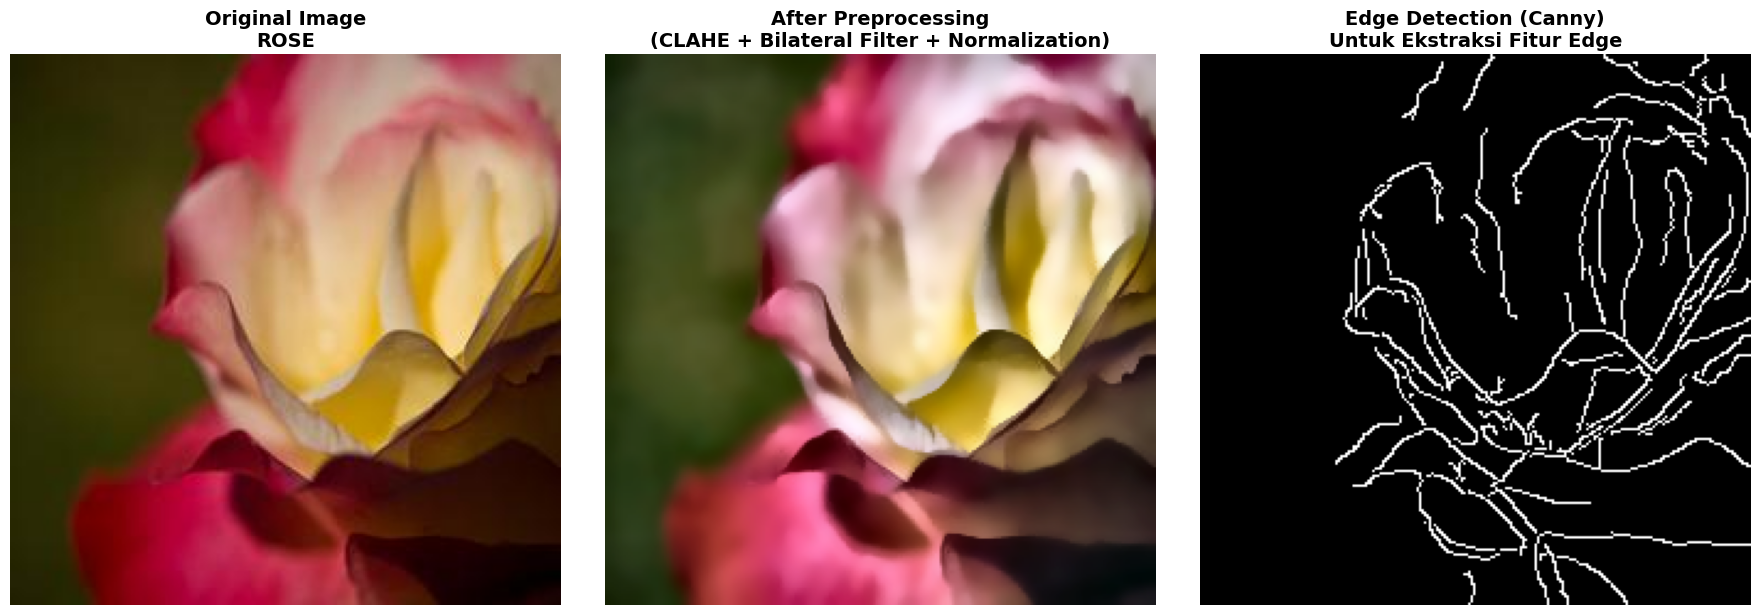

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(img_example)
axes[0].set_title(f"Original Image\n{example_class.upper()}", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Preprocessed image
axes[1].imshow(img_example_processed)
axes[1].set_title("After Preprocessing\n(CLAHE + Bilateral Filter + Normalization)", 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Edge detection visualization
gray = cv2.cvtColor(img_example_processed, cv2.COLOR_RGB2GRAY)
edges_canny = cv2.Canny(gray, 50, 150)
axes[2].imshow(edges_canny, cmap='gray')
axes[2].set_title("Edge Detection (Canny)\nUntuk Ekstraksi Fitur Edge", 
                  fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


#### Perhitungan jarak manhattan distance

- Mendefinisikan fungsi yang dibutuhkan

In [12]:
def extract_hu_moments_simple(image_path):
    """
    Ekstraksi Hu Moments (7 fitur bentuk) dari gambar
    Simple version tanpa preprocessing kompleks
    """
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (224, 224))
    
    # Hitung moments dan Hu moments
    moments = cv2.moments(img_resized)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Log transform agar nilai tidak terlalu besar
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    return hu_moments


def manhattan_distance(point1, point2):
    """
    City Block Distance: d = Σ|x_i - y_i|
    """
    return np.sum(np.abs(point1 - point2))


def calculate_centroids_simple(train_path, classes, num_samples=20):
    """
    Hitung centroid Hu Moments untuk setiap kelas
    """
    centroids = {}
    
    print("Menghitung centroid dari data training...")
    for class_name in classes:
        class_path = os.path.join(train_path, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        features_list = []
        for img_name in images[:num_samples]:
            img_path = os.path.join(class_path, img_name)
            hu = extract_hu_moments_simple(img_path)
            features_list.append(hu)
        
        centroid = np.mean(features_list, axis=0)
        centroids[class_name] = centroid
        print(f"✓ {class_name}: {len(features_list)} sampel")
    
    return centroids


def predict_with_manhattan(image_path, centroids):
    """
    Prediksi kelas gambar menggunakan Manhattan Distance
    """
    features = extract_hu_moments_simple(image_path)
    
    distances = {}
    for class_name, centroid in centroids.items():
        dist = manhattan_distance(features, centroid)
        distances[class_name] = dist
    
    predicted_class = min(distances, key=distances.get)
    
    return predicted_class, distances, features

In [13]:
data_path = "flower_classification/data"  
classes = ['bellflower', 'rose', 'sunflower', 'tulip']

print("="*70)
print("MENGHITUNG CENTROID SETIAP KELAS (Hu Moments)")
print("="*70)

# Hitung centroid dari 50 sampel per kelas
class_centroids = calculate_centroids_simple(data_path, classes, num_samples=50)

print("\n" + "="*70)
print("INFORMASI CENTROID")
print("="*70)

for class_name, centroid in class_centroids.items():
    print(f"\n{class_name.upper()}:")
    print(f"  Hu Moments: {centroid}")
    print(f"  Mean: {centroid.mean():.4f}, Std: {centroid.std():.4f}")

print("\n✓ Centroid berhasil dihitung!")

MENGHITUNG CENTROID SETIAP KELAS (Hu Moments)
Menghitung centroid dari data training...
✓ bellflower: 50 sampel
✓ rose: 50 sampel
✓ sunflower: 50 sampel
✓ tulip: 50 sampel

INFORMASI CENTROID

BELLFLOWER:
  Hu Moments: [ 2.8177163   8.0889498   9.83971617  9.90061854 -0.4        -1.20005466
  0.4       ]
  Mean: 4.2067, Std: 4.5685

ROSE:
  Hu Moments: [ 2.80951900e+00  7.84746835e+00  9.79228993e+00  9.87832928e+00
  5.49125190e-12 -7.99992635e-01 -1.60000000e+00]
  Mean: 3.9897, Std: 4.7014

SUNFLOWER:
  Hu Moments: [ 2.87309981  8.20871928  9.8640803   9.91939781  1.6        -3.19999873
  2.        ]
  Mean: 4.4665, Std: 4.6057

TULIP:
  Hu Moments: [ 2.83564994  8.32596017  9.83106309  9.87045261  6.4        -0.80000531
 -3.2       ]
  Mean: 4.7519, Std: 4.8582

✓ Centroid berhasil dihitung!
✓ sunflower: 50 sampel
✓ tulip: 50 sampel

INFORMASI CENTROID

BELLFLOWER:
  Hu Moments: [ 2.8177163   8.0889498   9.83971617  9.90061854 -0.4        -1.20005466
  0.4       ]
  Mean: 4.2067, S

KLASIFIKASI GAMBAR DENGAN MANHATTAN DISTANCE

File: D:\Code\ML-Kuliah\Project-Bunga\flower_classification\data\sunflower\7672205_9fa68c871f_c.jpg

NILAI EKSTRAKSI FITUR (Hu Moments - 7 fitur)
Fitur: [ 2.79831787  8.61985939  9.94979618  9.9652391  10.         -9.99999951
 10.        ]
Mean: 5.9047, Std: 6.9321

JARAK KE SETIAP KELAS (Manhattan Distance)
1. SUNFLOWER    →    23.8175 ← PREDIKSI (TERDEKAT)
2. TULIP        →    26.5447 
3. BELLFLOWER   →    29.5250 
4. ROSE         →    31.8280 

HASIL PREDIKSI: SUNFLOWER


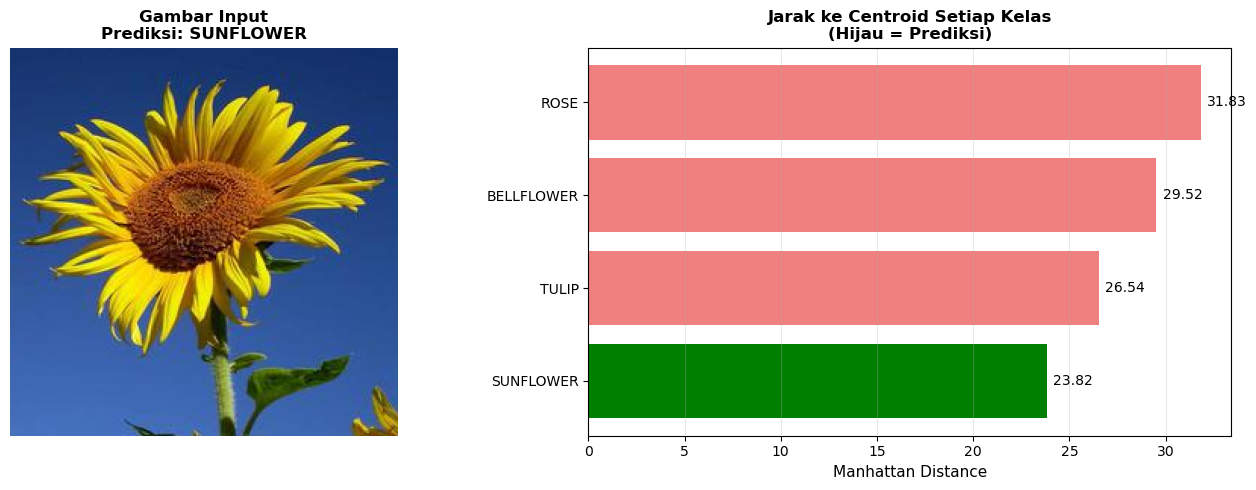

In [14]:
# GANTI PATH INI dengan gambar Anda
my_image_path = r"D:\Code\ML-Kuliah\Project-Bunga\flower_classification\data\sunflower\7672205_9fa68c871f_c.jpg"

print("="*70)
print("KLASIFIKASI GAMBAR DENGAN MANHATTAN DISTANCE")
print("="*70)
print(f"\nFile: {my_image_path}")

# Prediksi
predicted, distances, features = predict_with_manhattan(my_image_path, class_centroids)

print("\n" + "="*70)
print("NILAI EKSTRAKSI FITUR (Hu Moments - 7 fitur)")
print("="*70)
print(f"Fitur: {features}")
print(f"Mean: {features.mean():.4f}, Std: {features.std():.4f}")

print("\n" + "="*70)
print("JARAK KE SETIAP KELAS (Manhattan Distance)")
print("="*70)

# Urutkan dari terdekat ke terjauh
sorted_distances = sorted(distances.items(), key=lambda x: x[1])

for rank, (class_name, dist) in enumerate(sorted_distances, 1):
    marker = "← PREDIKSI (TERDEKAT)" if class_name == predicted else ""
    print(f"{rank}. {class_name.upper():12} → {dist:>10.4f} {marker}")

print("\n" + "="*70)
print(f"HASIL PREDIKSI: {predicted.upper()}")
print("="*70)

# Visualisasi
img = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gambar
axes[0].imshow(img_rgb)
axes[0].set_title(f'Gambar Input\nPrediksi: {predicted.upper()}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Bar chart jarak
class_names = [name.upper() for name, _ in sorted_distances]
distance_values = [dist for _, dist in sorted_distances]
colors = ['green' if name.lower() == predicted else 'lightcoral' for name, _ in sorted_distances]

axes[1].barh(class_names, distance_values, color=colors)
axes[1].set_xlabel('Manhattan Distance', fontsize=11)
axes[1].set_title('Jarak ke Centroid Setiap Kelas\n(Hijau = Prediksi)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, (_, dist) in enumerate(sorted_distances):
    axes[1].text(dist + max(distance_values)*0.01, i, f'{dist:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Training Data

In [15]:
def process_single_image(img_path, class_name):
    """
    Proses 1 gambar secara paralel: load → preprocess → extract features
    
    Returns:
        tuple: (features_list, class_name) 
    """
    try:
        # 1. Load image
        img = cv2.imread(img_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 2. Preprocessing (resize, CLAHE, bilateral, normalize)
        img_preprocessed = preprocess_image(img)
        
        # 3. Ekstraksi fitur 
        color_features = extract_hsv_features(img_preprocessed)       # 18 fitur
        shape_features = extract_hu_moments(img_preprocessed)         # 7 fitur
        texture_features = extract_texture_features(img_preprocessed) # 10 fitur
        edge_features = extract_edge_features(img_preprocessed)       # 6 fitur
        
        # 4. Gabungkan semua fitur
        combined_features = (color_features + 
                            list(shape_features) + 
                            texture_features + 
                            edge_features)
        
        return combined_features, class_name
        
    except Exception as e:
        return None

- Training data dan memberi bobot pada setiap fitur ekstraksi

In [16]:
from sklearn.model_selection import train_test_split

data_path = "flower_classification/data"  
classes = ['bellflower', 'rose', 'sunflower', 'tulip']

print("\n" + "="*70)
print("⚡ EKSTRAKSI FITUR DARI DATASET (OPTIMIZED)")
print("="*70)
print("METODE: Multiprocessing + skimage LBP + tqdm progress bar")
print("="*70)

# Step 1: Kumpulkan semua path gambar terlebih dahulu
print("\nStep 1: Mengumpulkan path semua gambar...")
all_image_paths = []
all_class_labels = []

for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    image_files = [f for f in os.listdir(class_path) 
                   if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        all_image_paths.append(img_path)
        all_class_labels.append(class_name)
    
    print(f"  {class_name}: {len(image_files)} gambar")

print(f"\n✓ Total gambar ditemukan: {len(all_image_paths)}")

# Step 2: Proses PARALEL dengan multiprocessing (5-10x lebih cepat!)
print(f"\nStep 2: Memproses {len(all_image_paths)} gambar secara PARALEL...")
print(f"⚡ Menggunakan {multiprocessing.cpu_count()} CPU cores")
print("⏳ Estimasi waktu: ~30-90 detik (tergantung CPU)")
print("\nProgress:")

# Parallel processing dengan progress bar (tqdm)
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_single_image)(img_path, class_name) 
    for img_path, class_name in tqdm(
        zip(all_image_paths, all_class_labels), 
        total=len(all_image_paths),
        desc="⚡ Processing",
        unit="img",
        ncols=100
    )
)

# Step 3: Filter hasil yang valid (buang yang error)
all_features = []
all_labels = []
error_count = 0

for result in results:
    if result is not None:
        features, label = result
        all_features.append(features)
        all_labels.append(label)
    else:
        error_count += 1

# Convert ke numpy array
X_all = np.array(all_features)
y_all = np.array(all_labels)

print(f"\n{'='*70}")
print("HASIL EKSTRAKSI FITUR")
print(f"{'='*70}")
print(f"✓ Berhasil diproses: {len(X_all)} gambar")
if error_count > 0:
    print(f"⚠ Gagal/skip: {error_count} gambar")
print(f"✓ Total fitur per gambar: {X_all.shape[1]}")

# Step 4: Split 80:20 dengan stratifikasi
print(f"\nStep 4: Membagi dataset 80:20 (train:val) dengan stratifikasi...")
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, 
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("\n" + "="*70)
print("SPLIT DATASET SELESAI")
print("="*70)
print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X_all)*100:.1f}%)")
print(f"Validation samples: {X_val.shape[0]} ({X_val.shape[0]/len(X_all)*100:.1f}%)")
print(f"Total features: {X_train.shape[1]}")
print(f"  - 18 Color features (HSV, LAB, RGB)")
print(f"  - 7 Shape features (Hu Moments)")
print(f"  - 10 Texture features (LBP)")
print(f"  - 6 Edge features (Canny + Sobel)")

print("\nDistribusi per kelas:")
from collections import Counter
train_counts = Counter(y_train)
val_counts = Counter(y_val)
for class_name in classes:
    print(f"  {class_name:12} → Train: {train_counts[class_name]:4}, Val: {val_counts[class_name]:3}")
print("="*70)

# APPLY FEATURE WEIGHTING
print("\n" + "="*70)
print("MENERAPKAN PEMBOBOTAN FITUR (FEATURE WEIGHTING)")
print("="*70)

feature_weights = {
    'color': 1.5,
    'shape': 1.2,
    'texture': 1.0,
    'edge': 0.8
}

print("\nBobot yang digunakan:")
print(f"Color Features   : {feature_weights['color']}")
print(f"Shape Features   : {feature_weights['shape']}")
print(f"Texture Features : {feature_weights['texture']}")
print(f"Edge Features    : {feature_weights['edge']}")

X_train_weighted = apply_feature_weighting(X_train, feature_weights)
X_val_weighted = apply_feature_weighting(X_val, feature_weights)

print("\n✓ Feature weighting selesai!")
print("="*70)


⚡ EKSTRAKSI FITUR DARI DATASET (OPTIMIZED)
METODE: Multiprocessing + skimage LBP + tqdm progress bar

Step 1: Mengumpulkan path semua gambar...
  bellflower: 879 gambar
  rose: 993 gambar
  sunflower: 1020 gambar
  tulip: 1041 gambar

✓ Total gambar ditemukan: 3933

Step 2: Memproses 3933 gambar secara PARALEL...
⚡ Menggunakan 16 CPU cores
⏳ Estimasi waktu: ~30-90 detik (tergantung CPU)

Progress:


⚡ Processing: 100%|██████████████████████████████████████████| 3933/3933 [00:25<00:00, 154.65img/s]




HASIL EKSTRAKSI FITUR
✓ Berhasil diproses: 3933 gambar
✓ Total fitur per gambar: 41

Step 4: Membagi dataset 80:20 (train:val) dengan stratifikasi...

SPLIT DATASET SELESAI
Training samples: 3146 (80.0%)
Validation samples: 787 (20.0%)
Total features: 41
  - 18 Color features (HSV, LAB, RGB)
  - 7 Shape features (Hu Moments)
  - 10 Texture features (LBP)
  - 6 Edge features (Canny + Sobel)

Distribusi per kelas:
  bellflower   → Train:  703, Val: 176
  rose         → Train:  794, Val: 199
  sunflower    → Train:  816, Val: 204
  tulip        → Train:  833, Val: 208

MENERAPKAN PEMBOBOTAN FITUR (FEATURE WEIGHTING)

Bobot yang digunakan:
Color Features   : 1.5
Shape Features   : 1.2
Texture Features : 1.0
Edge Features    : 0.8

✓ Feature weighting selesai!


- Pemberian label pada setiap kelas dan normalisasi pada fitur yang sudah diberi bobot

In [17]:
print("\nPREPROCESSING FEATURES...")

# Label Encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

print(f"\nLabel Mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name} → {i}")

# Feature Scaling/Normalization (pada fitur yang sudah diberi bobot)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_weighted)
X_val_scaled = scaler.transform(X_val_weighted)

print(f"\nSetelah scaling:")
print(f"  Mean: {X_train_scaled.mean():.6f} (seharusnya ≈ 0)")
print(f"  Std: {X_train_scaled.std():.6f} (seharusnya ≈ 1)")


PREPROCESSING FEATURES...

Label Mapping:
  bellflower → 0
  rose → 1
  sunflower → 2
  tulip → 3

Setelah scaling:
  Mean: 0.000000 (seharusnya ≈ 0)
  Std: 1.000000 (seharusnya ≈ 1)


- Membuat model SVM

In [18]:
print("\n" + "="*70)
print("TRAINING MODEL SVM")
print("="*70)

# Hyperparameter tuning - EXPANDED RANGE
param_grid_svm = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

print("Melakukan Grid Search untuk SVM...")
svm_model = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'), 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_model.fit(X_train_scaled, y_train_encoded)

print(f"\nBest SVM Parameters: {svm_model.best_params_}")
print(f"Best Cross-Validation Score: {svm_model.best_score_:.4f}")

# Prediksi
y_pred_svm_train = svm_model.predict(X_train_scaled)
y_pred_svm_val = svm_model.predict(X_val_scaled)



TRAINING MODEL SVM
Melakukan Grid Search untuk SVM...
Fitting 5 folds for each of 108 candidates, totalling 540 fits



Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8674


- Membuat model KNN

In [19]:
print("\n" + "="*70)
print("TRAINING MODEL KNN")
print("="*70)

# Hyperparameter tuning - EXPANDED RANGE
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2, 3]  # untuk minkowski metric
}

print("Melakukan Grid Search untuk KNN...")
knn_model = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid_knn, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_model.fit(X_train_scaled, y_train_encoded)

print(f"\nBest KNN Parameters: {knn_model.best_params_}")
print(f"Best Cross-Validation Score: {knn_model.best_score_:.4f}")

# Prediksi
y_pred_knn_train = knn_model.predict(X_train_scaled)
y_pred_knn_val = knn_model.predict(X_val_scaled)



TRAINING MODEL KNN
Melakukan Grid Search untuk KNN...
Fitting 5 folds for each of 126 candidates, totalling 630 fits

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Score: 0.8039

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Score: 0.8039


### Evaluasi

- Evaluasi akurasi pada training data (mengecek apakah model berhasil belajar dari data training)

In [20]:
print("\n" + "="*70)
print("EVALUASI PADA TRAINING DATA")
print("="*70)

print("\nSVM - Training Accuracy:")
acc_svm_train = accuracy_score(y_train_encoded, y_pred_svm_train)
print(f"Accuracy: {acc_svm_train:.4f} ({acc_svm_train*100:.2f}%)")

print("\nKNN - Training Accuracy:")
acc_knn_train = accuracy_score(y_train_encoded, y_pred_knn_train)
print(f"Accuracy: {acc_knn_train:.4f} ({acc_knn_train*100:.2f}%)")


EVALUASI PADA TRAINING DATA

SVM - Training Accuracy:
Accuracy: 0.9526 (95.26%)

KNN - Training Accuracy:
Accuracy: 1.0000 (100.00%)


- Evaluasi akurasi pada validation data + classification report (precision, recall, F1-score per kelas)

In [21]:
print("\n" + "="*70)
print("EVALUASI PADA VALIDATION DATA")
print("="*70)

print("\nSVM - Validation Results:")
print("="*70)
acc_svm_val = accuracy_score(y_val_encoded, y_pred_svm_val)
print(f"Accuracy: {acc_svm_val:.4f} ({acc_svm_val*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred_svm_val, target_names=le.classes_))

print("\nKNN - Validation Results:")
print("="*70)
acc_knn_val = accuracy_score(y_val_encoded, y_pred_knn_val)
print(f"Accuracy: {acc_knn_val:.4f} ({acc_knn_val*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred_knn_val, target_names=le.classes_))


EVALUASI PADA VALIDATION DATA

SVM - Validation Results:
Accuracy: 0.8742 (87.42%)

Classification Report:
              precision    recall  f1-score   support

  bellflower       0.83      0.88      0.86       176
        rose       0.84      0.80      0.82       199
   sunflower       0.94      0.96      0.95       204
       tulip       0.88      0.86      0.87       208

    accuracy                           0.87       787
   macro avg       0.87      0.87      0.87       787
weighted avg       0.87      0.87      0.87       787


KNN - Validation Results:
Accuracy: 0.7903 (79.03%)

Classification Report:
              precision    recall  f1-score   support

  bellflower       0.82      0.73      0.77       176
        rose       0.67      0.76      0.71       199
   sunflower       0.84      0.94      0.89       204
       tulip       0.85      0.72      0.78       208

    accuracy                           0.79       787
   macro avg       0.80      0.79      0.79       787


- Visualisasi confusion matrix untuk SVM dan KNN (melihat pola kesalahan prediksi per kelas)

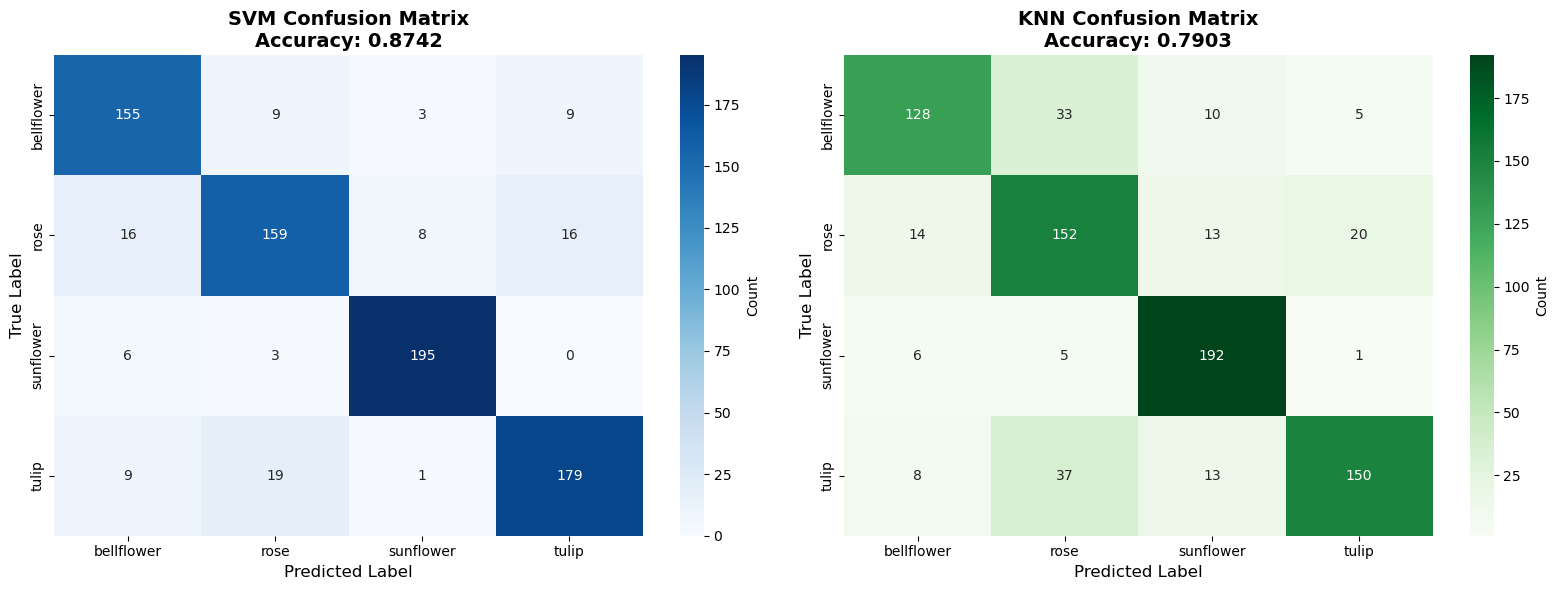

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_val_encoded, y_pred_svm_val)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, 
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'SVM Confusion Matrix\nAccuracy: {acc_svm_val:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_val_encoded, y_pred_knn_val)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, 
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'KNN Confusion Matrix\nAccuracy: {acc_knn_val:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()


- Membandingkan performa model SVM dan KNN


PERBANDINGAN PERFORMA MODEL

 Model  Training Accuracy  Validation Accuracy                                                           Best Parameters
  SVM           0.952638             0.874206                                 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
  KNN           1.000000             0.790343 {'metric': 'euclidean', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


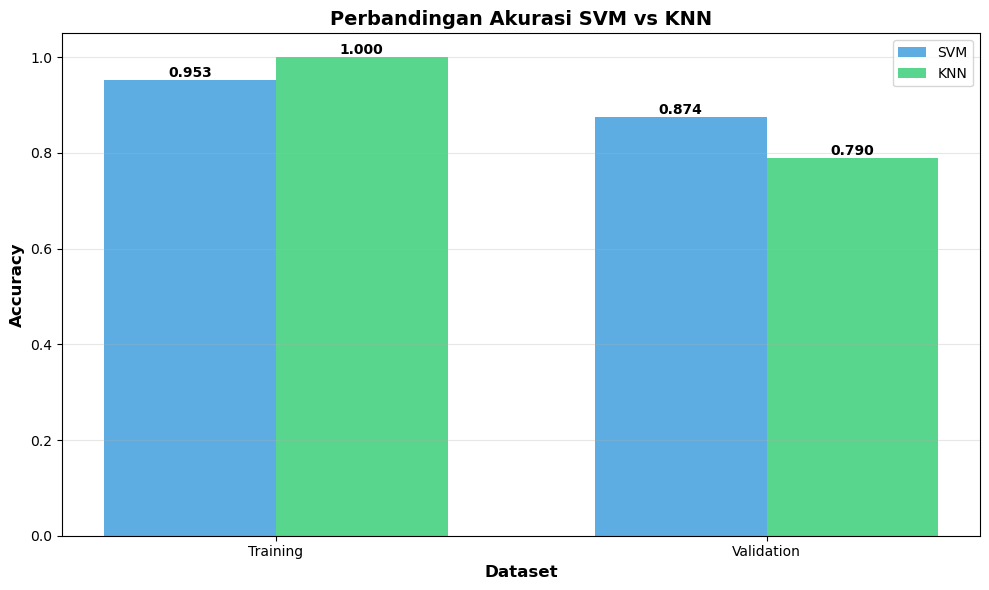

In [23]:
print("\n" + "="*70)
print("PERBANDINGAN PERFORMA MODEL")
print("="*70)

# Tabel perbandingan
comparison_df = pd.DataFrame({
    'Model': ['SVM', 'KNN'],
    'Training Accuracy': [acc_svm_train, acc_knn_train],
    'Validation Accuracy': [acc_svm_val, acc_knn_val],
    'Best Parameters': [
        str(svm_model.best_params_),
        str(knn_model.best_params_)
    ]
})

print("\n", comparison_df.to_string(index=False))

# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(['Training', 'Validation']))
width = 0.35

bars1 = ax.bar(x - width/2, [acc_svm_train, acc_svm_val], width, 
               label='SVM', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, [acc_knn_train, acc_knn_val], width, 
               label='KNN', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Akurasi SVM vs KNN', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Validation'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

- Summary tabel perbandingan semua metrik (precision, recall, F1-score, accuracy)

In [24]:
print("\n" + "="*70)
print("KESIMPULAN")
print("="*70)

best_model = "SVM" if acc_svm_val > acc_knn_val else "KNN"
best_accuracy = max(acc_svm_val, acc_knn_val)

print(f"\n✓ Model terbaik: {best_model}")
print(f"✓ Akurasi tertinggi: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"\n✓ Total fitur yang digunakan: {X_train.shape[1]}")
print(f"  - 18 fitur Color (HSV + LAB + RGB)")
print(f"  - 7 fitur Shape (Hu Moments)")
print(f"  - 10 fitur Texture (LBP)")
print(f"  - 6 fitur Edge (Canny + Sobel)")
print(f"\n✓ Preprocessing techniques:")
print(f"  - CLAHE (Contrast Limited Adaptive Histogram Equalization)")
print(f"  - Bilateral Filtering (noise reduction + edge preservation)")
print(f"  - Color Normalization")
print(f"\n✓ Dataset:")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Validation samples: {X_val.shape[0]}")
print(f"  - Classes: {', '.join(classes)}")

print("\n" + "="*70)
print("PROSES SELESAI!")
print("="*70)



KESIMPULAN

✓ Model terbaik: SVM
✓ Akurasi tertinggi: 0.8742 (87.42%)

✓ Total fitur yang digunakan: 41
  - 18 fitur Color (HSV + LAB + RGB)
  - 7 fitur Shape (Hu Moments)
  - 10 fitur Texture (LBP)
  - 6 fitur Edge (Canny + Sobel)

✓ Preprocessing techniques:
  - CLAHE (Contrast Limited Adaptive Histogram Equalization)
  - Bilateral Filtering (noise reduction + edge preservation)
  - Color Normalization

✓ Dataset:
  - Training samples: 3146
  - Validation samples: 787
  - Classes: bellflower, rose, sunflower, tulip

PROSES SELESAI!


- Membuat visualisasi kesimpulan akhir

In [25]:
from matplotlib.gridspec import GridSpec

print("\n" + "="*70)
print("MEMBUAT VISUALISASI AKHIR")
print("="*70)

# Path untuk sample gambar training (1 per kelas)
sample_train_paths = {
    'bellflower': None,
    'rose': None,
    'sunflower': None,
    'tulip': None
}

# Ambil 1 gambar pertama dari setiap kelas
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        sample_train_paths[class_name] = os.path.join(class_path, images[0])

# Path untuk gambar test (ambil 1 dari validation)
test_class = 'rose'  # Bisa diganti sesuai keinginan
test_path_dir = os.path.join(data_path, test_class)
test_images = [f for f in os.listdir(test_path_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
test_image_path = os.path.join(test_path_dir, test_images[0]) if test_images else None

print(f"✓ Sample gambar training: {len(sample_train_paths)} kelas")
print(f"✓ Gambar test dari kelas: {test_class}")


MEMBUAT VISUALISASI AKHIR
✓ Sample gambar training: 4 kelas
✓ Gambar test dari kelas: rose


#### Hitung Centroid untuk Rejection Mechanism (41 Fitur)

In [26]:
print("\n" + "="*70)
print("MENGHITUNG CENTROID UNTUK REJECTION MECHANISM")
print("="*70)

# Hitung centroid dari training data (weighted features)
class_centroids_full = {}

for class_name in classes:
    # Ambil index untuk class ini dari training data
    class_indices = [i for i, label in enumerate(all_labels) if label == class_name and i < len(X_train_weighted)]
    
    if class_indices:
        # Ambil fitur weighted untuk class ini
        class_features = X_train_weighted[class_indices]
        
        # Hitung centroid (mean dari semua fitur)
        centroid = np.mean(class_features, axis=0)
        class_centroids_full[class_name] = centroid
        
        print(f"✓ {class_name.capitalize():<12}: Centroid dari {len(class_indices)} samples (shape: {centroid.shape})")

print(f"\n✓ Total centroids: {len(class_centroids_full)} kelas")
print(f"✓ Dimensi setiap centroid: 41 fitur (lengkap)")
print("="*70)


MENGHITUNG CENTROID UNTUK REJECTION MECHANISM
✓ Bellflower  : Centroid dari 879 samples (shape: (41,))
✓ Rose        : Centroid dari 993 samples (shape: (41,))
✓ Sunflower   : Centroid dari 1020 samples (shape: (41,))
✓ Tulip       : Centroid dari 254 samples (shape: (41,))

✓ Total centroids: 4 kelas
✓ Dimensi setiap centroid: 41 fitur (lengkap)


In [27]:
# Load training samples
train_samples = {}
train_features_hsv = {}

for class_name, path in sample_train_paths.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed = preprocess_image(img)
    
    train_samples[class_name] = img
    
    # Ekstrak fitur HSV untuk plotting
    hsv = cv2.cvtColor(img_processed, cv2.COLOR_RGB2HSV)
    train_features_hsv[class_name] = {
        'H': np.mean(hsv[:,:,0]),
        'S': np.mean(hsv[:,:,1]),
        'V': np.mean(hsv[:,:,2])
    }

# Load test image
test_img = cv2.imread(test_image_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_processed = preprocess_image(test_img)

# Ekstrak fitur dari test image
test_hsv = cv2.cvtColor(test_img_processed, cv2.COLOR_RGB2HSV)
test_features_hsv = {
    'H': np.mean(test_hsv[:,:,0]),
    'S': np.mean(test_hsv[:,:,1]),
    'V': np.mean(test_hsv[:,:,2])
}

# Ekstrak fitur lengkap untuk prediksi (semua 41 fitur)
test_color_features = extract_hsv_features(test_img_processed)  # 18 fitur
test_shape_features = extract_hu_moments(test_img_processed)    # 7 fitur
test_texture_features = extract_texture_features(test_img_processed)  # 10 fitur
test_edge_features = extract_edge_features(test_img_processed)  # 6 fitur

test_combined_features = np.array([test_color_features + 
                                    list(test_shape_features) + 
                                    test_texture_features + 
                                    test_edge_features])

# Apply feature weighting
test_features_weighted = apply_feature_weighting(test_combined_features, feature_weights)
test_features_scaled = scaler.transform(test_features_weighted)

# Prediksi
pred_svm = svm_model.predict(test_features_scaled)[0]
pred_knn = knn_model.predict(test_features_scaled)[0]

pred_svm_label = le.inverse_transform([pred_svm])[0]
pred_knn_label = le.inverse_transform([pred_knn])[0]

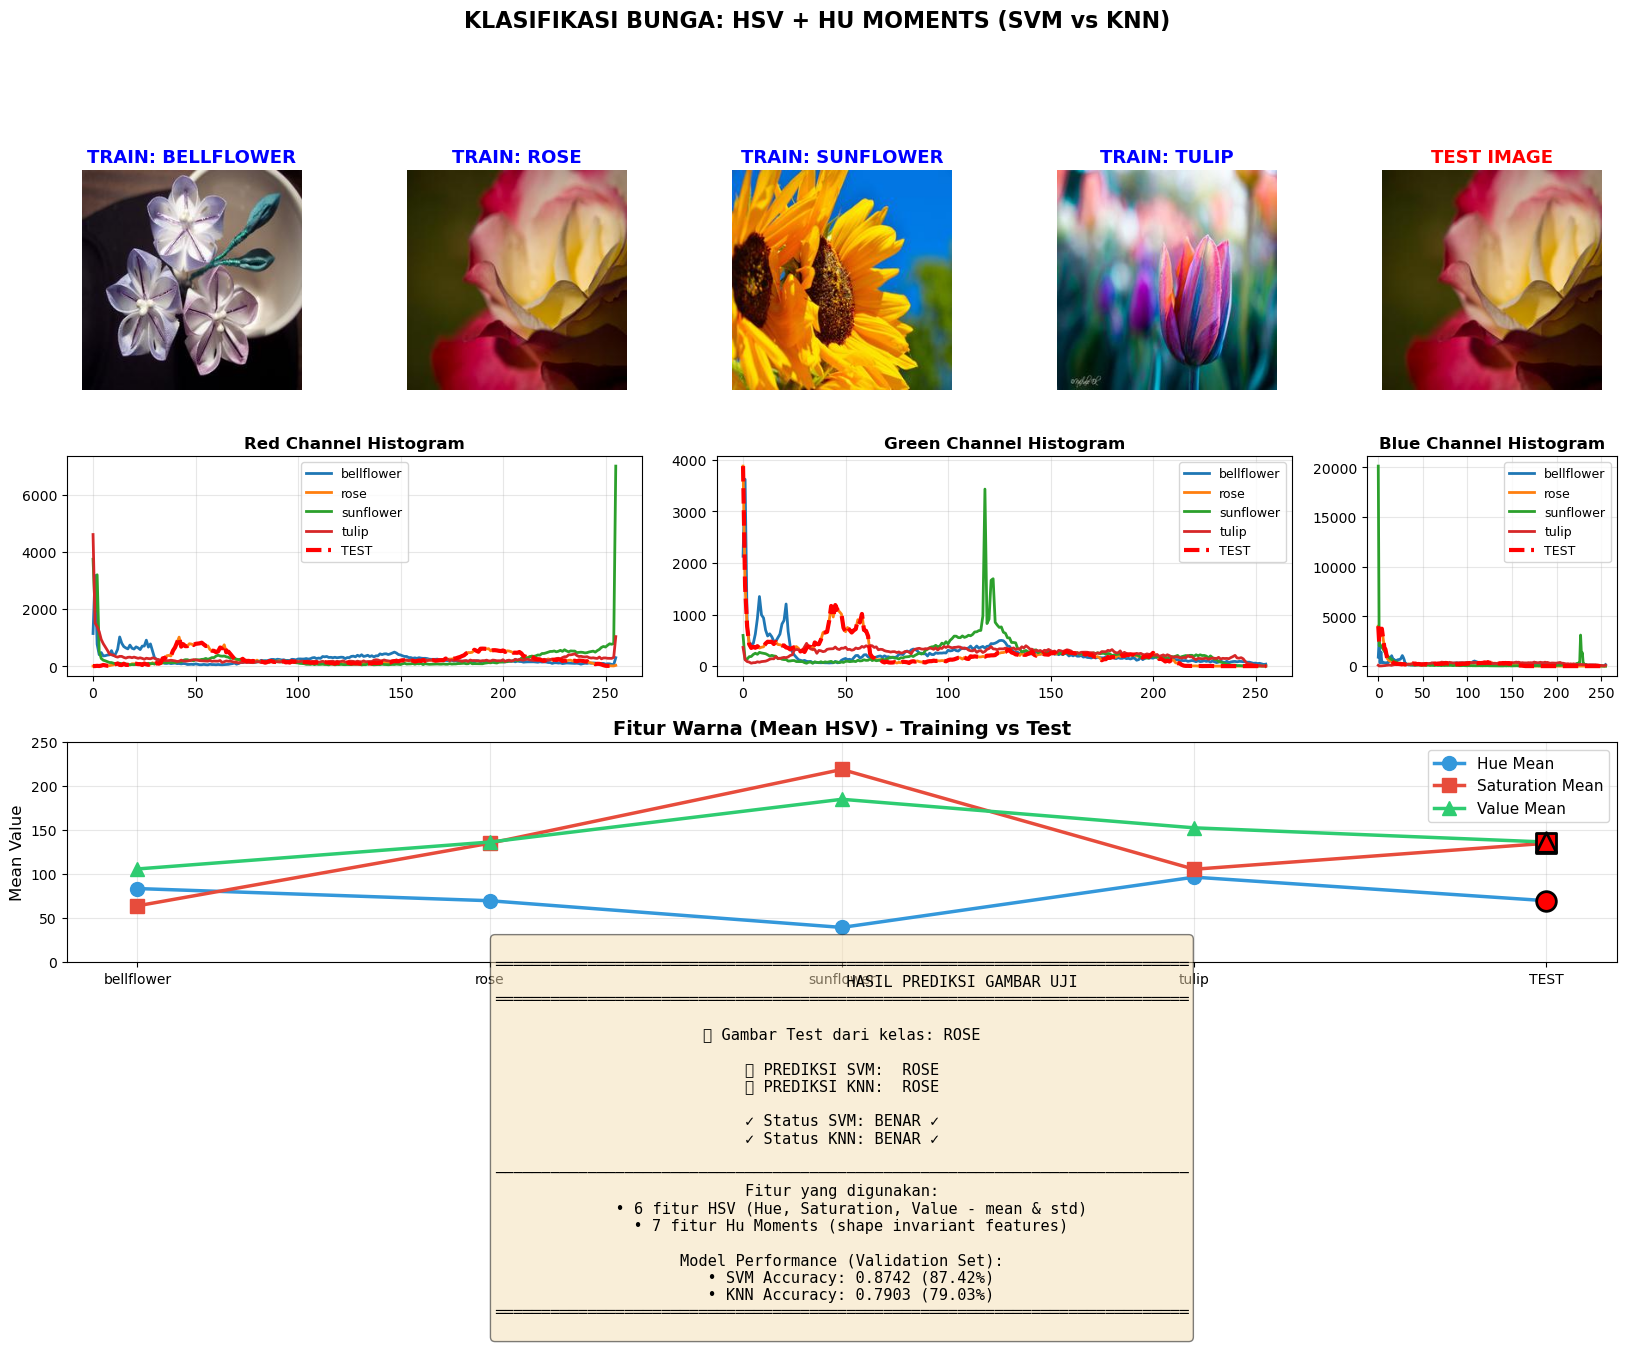

In [28]:
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(4, 5, figure=fig, hspace=0.3, wspace=0.3)

# ========== BARIS 1: GAMBAR TRAINING + TEST ==========
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(train_samples[class_name])
    ax.set_title(f"TRAIN: {class_name.upper()}", 
                 fontsize=13, fontweight='bold', color='blue')
    ax.axis('off')
    # Border biru untuk training
    for spine in ax.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(3)
        spine.set_visible(True)

# Gambar TEST
ax = fig.add_subplot(gs[0, 4])
ax.imshow(test_img)
ax.set_title(f"TEST IMAGE", 
             fontsize=13, fontweight='bold', color='red')
ax.axis('off')
# Border merah untuk test
for spine in ax.spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)
    spine.set_visible(True)

# ========== BARIS 2: HISTOGRAM RGB ==========
# Red Channel
ax = fig.add_subplot(gs[1, 0:2])
for class_name, img in train_samples.items():
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    ax.plot(hist, label=f"{class_name}", linewidth=2)
hist_test_r = cv2.calcHist([test_img], [0], None, [256], [0, 256])
ax.plot(hist_test_r, label="TEST", linewidth=3, linestyle='--', color='red')
ax.set_title("Red Channel Histogram", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Green Channel
ax = fig.add_subplot(gs[1, 2:4])
for class_name, img in train_samples.items():
    hist = cv2.calcHist([img], [1], None, [256], [0, 256])
    ax.plot(hist, label=f"{class_name}", linewidth=2)
hist_test_g = cv2.calcHist([test_img], [1], None, [256], [0, 256])
ax.plot(hist_test_g, label="TEST", linewidth=3, linestyle='--', color='red')
ax.set_title("Green Channel Histogram", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Blue Channel
ax = fig.add_subplot(gs[1, 4])
for class_name, img in train_samples.items():
    hist = cv2.calcHist([img], [2], None, [256], [0, 256])
    ax.plot(hist, label=f"{class_name}", linewidth=2)
hist_test_b = cv2.calcHist([test_img], [2], None, [256], [0, 256])
ax.plot(hist_test_b, label="TEST", linewidth=3, linestyle='--', color='red')
ax.set_title("Blue Channel Histogram", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# ========== BARIS 3: FITUR HSV (MEAN) ==========
ax = fig.add_subplot(gs[2, :])

# Data untuk plotting
train_names = list(train_features_hsv.keys())
h_means = [train_features_hsv[c]['H'] for c in train_names]
s_means = [train_features_hsv[c]['S'] for c in train_names]
v_means = [train_features_hsv[c]['V'] for c in train_names]

# Tambahkan test data
all_names = train_names + ['TEST']
h_means.append(test_features_hsv['H'])
s_means.append(test_features_hsv['S'])
v_means.append(test_features_hsv['V'])

# Plot
ax.plot(all_names, h_means, marker='o', label='Hue Mean', 
        linewidth=2.5, markersize=10, color='#3498db')
ax.plot(all_names, s_means, marker='s', label='Saturation Mean', 
        linewidth=2.5, markersize=10, color='#e74c3c')
ax.plot(all_names, v_means, marker='^', label='Value Mean', 
        linewidth=2.5, markersize=10, color='#2ecc71')

# Highlight test point
ax.scatter(['TEST'], [h_means[-1]], s=200, marker='o', 
           color='red', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(['TEST'], [s_means[-1]], s=200, marker='s', 
           color='red', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(['TEST'], [v_means[-1]], s=200, marker='^', 
           color='red', edgecolors='black', linewidths=2, zorder=5)

ax.set_title("Fitur Warna (Mean HSV) - Training vs Test", 
             fontsize=14, fontweight='bold')
ax.set_ylabel("Mean Value", fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 250)

# ========== BARIS 4: HASIL PREDIKSI ==========
ax = fig.add_subplot(gs[3, :])
ax.axis('off')

# Info box
result_text = f"""
═══════════════════════════════════════════════════════════════════════════
                          HASIL PREDIKSI GAMBAR UJI
═══════════════════════════════════════════════════════════════════════════

📸 Gambar Test dari kelas: {test_class.upper()}

🔵 PREDIKSI SVM:  {pred_svm_label.upper()}
🟢 PREDIKSI KNN:  {pred_knn_label.upper()}

✓ Status SVM: {"BENAR ✓" if pred_svm_label == test_class else "SALAH ✗"}
✓ Status KNN: {"BENAR ✓" if pred_knn_label == test_class else "SALAH ✗"}

───────────────────────────────────────────────────────────────────────────
Fitur yang digunakan:
  • 6 fitur HSV (Hue, Saturation, Value - mean & std)
  • 7 fitur Hu Moments (shape invariant features)
  
Model Performance (Validation Set):
  • SVM Accuracy: {acc_svm_val:.4f} ({acc_svm_val*100:.2f}%)
  • KNN Accuracy: {acc_knn_val:.4f} ({acc_knn_val*100:.2f}%)
═══════════════════════════════════════════════════════════════════════════
"""

ax.text(0.5, 0.5, result_text, 
        fontsize=11, ha='center', va='center',
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("KLASIFIKASI BUNGA: HSV + HU MOMENTS (SVM vs KNN)", 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

In [29]:
def visualize_prediction_simple(result):
    """
    Visualisasi hasil prediksi - versi simple
    """
    img = result['image']
    processed = result['processed']
    true_label = result['true_label']
    svm_pred = result['svm_prediction']
    knn_pred = result['knn_prediction']
    svm_conf = result['svm_confidence']
    knn_conf = result['knn_confidence']
    hsv_values = result['hsv']
    
    # Create figure
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    # ===== ROW 1: IMAGES =====
    # Original image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img)
    ax1.set_title("Original Image", fontsize=13, fontweight='bold')
    ax1.axis('off')
    for spine in ax1.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(3)
        spine.set_visible(True)
    
    # Processed image
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(processed)
    ax2.set_title("Preprocessed (224x224)", fontsize=13, fontweight='bold')
    ax2.axis('off')
    
    # True label display
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    ax3.text(0.5, 0.5, f"TRUE LABEL:\n\n{true_label.upper()}", 
             fontsize=20, ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # ===== ROW 2: PREDICTIONS =====
    # SVM Result
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    svm_correct = svm_pred == true_label
    svm_color = '#d5f4e6' if svm_correct else '#fadbd8'
    svm_icon = '✓' if svm_correct else '✗'
    
    svm_text = f"""
SVM PREDICTION

{svm_pred.upper()}

Confidence: {svm_conf:.1f}%

{svm_icon} {'CORRECT' if svm_correct else 'WRONG'}
    """
    ax4.text(0.5, 0.5, svm_text, fontsize=14, ha='center', va='center',
             fontweight='bold', family='monospace',
             bbox=dict(boxstyle='round', facecolor=svm_color, alpha=0.8))
    
    # KNN Result
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.axis('off')
    knn_correct = knn_pred == true_label
    knn_color = '#d5f4e6' if knn_correct else '#fadbd8'
    knn_icon = '✓' if knn_correct else '✗'
    
    knn_text = f"""
KNN PREDICTION

{knn_pred.upper()}

Confidence: {knn_conf:.1f}%

{knn_icon} {'CORRECT' if knn_correct else 'WRONG'}
    """
    ax5.text(0.5, 0.5, knn_text, fontsize=14, ha='center', va='center',
             fontweight='bold', family='monospace',
             bbox=dict(boxstyle='round', facecolor=knn_color, alpha=0.8))
    
    # Confidence comparison
    ax6 = fig.add_subplot(gs[1, 2])
    models = ['SVM', 'KNN']
    confidences = [svm_conf, knn_conf]
    colors_bar = ['#3498db', '#2ecc71']
    
    bars = ax6.barh(models, confidences, color=colors_bar, alpha=0.7, 
                    edgecolor='black', linewidth=2)
    ax6.set_xlabel('Confidence (%)', fontsize=11, fontweight='bold')
    ax6.set_title('Confidence Comparison', fontsize=13, fontweight='bold')
    ax6.set_xlim(0, 100)
    ax6.grid(axis='x', alpha=0.3)
    
    for bar, conf in zip(bars, confidences):
        ax6.text(conf + 2, bar.get_y() + bar.get_height()/2, 
                f'{conf:.1f}%', va='center', fontweight='bold')
    
    # ===== ROW 3: FEATURES =====
    # HSV Values
    ax7 = fig.add_subplot(gs[2, 0])
    channels = ['Hue', 'Saturation', 'Value']
    values = [hsv_values['H'], hsv_values['S'], hsv_values['V']]
    colors_hsv = ['#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax7.bar(channels, values, color=colors_hsv, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    ax7.set_title('Mean HSV Features', fontsize=13, fontweight='bold')
    ax7.set_ylabel('Mean Value', fontsize=11)
    ax7.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, values):
        ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{val:.1f}', ha='center', fontweight='bold')
    
    # Histogram RGB
    ax8 = fig.add_subplot(gs[2, 1:])
    for i, (color, name) in enumerate(zip(['r', 'g', 'b'], ['Red', 'Green', 'Blue'])):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ax8.plot(hist, color=color, label=name, linewidth=2, alpha=0.7)
    
    ax8.set_title('RGB Histogram', fontsize=13, fontweight='bold')
    ax8.set_xlabel('Pixel Value', fontsize=11)
    ax8.set_ylabel('Frequency', fontsize=11)
    ax8.legend()
    ax8.grid(alpha=0.3)
    
    # Main title
    plt.suptitle('HASIL PREDIKSI KLASIFIKASI BUNGA', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print("\n" + "="*70)
    print("SUMMARY HASIL PREDIKSI")
    print("="*70)
    print(f"True Label       : {true_label.upper()}")
    print(f"SVM Prediction   : {svm_pred.upper()} ({svm_conf:.1f}%) - {svm_icon} {'CORRECT' if svm_correct else 'WRONG'}")
    print(f"KNN Prediction   : {knn_pred.upper()} ({knn_conf:.1f}%) - {knn_icon} {'CORRECT' if knn_correct else 'WRONG'}")
    print("-"*70)
    
    if svm_correct and knn_correct:
        print("Kedua model memprediksi dengan BENAR!")
        winner = "BOTH"
    elif svm_correct:
        print("SVM BENAR, KNN salah")
        winner = "SVM"
    elif knn_correct:
        print("KNN BENAR, SVM salah")
        winner = "KNN"
    else:
        print("Kedua model memprediksi SALAH")
        winner = "NONE"
    
    print(f"Winner: {winner}")
    print("="*70)
    

In [30]:
def visualize_prediction_with_rejection(result):
    """
    Visualisasi hasil prediksi dengan rejection indicator
    """
    img = result['image']
    processed = result['processed']
    true_label = result['true_label']
    svm_pred = result['svm_prediction']
    knn_pred = result['knn_prediction']
    svm_conf = result['svm_confidence']
    knn_conf = result['knn_confidence']
    hsv_values = result['hsv']
    is_rejected = result['is_rejected']
    rejection_reasons = result['rejection_reasons']
    distances = result['distances_to_centroids']
    
    # Setup figure dengan rejection banner jika perlu
    if is_rejected:
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, height_ratios=[0.5, 2, 2, 2], hspace=0.3, wspace=0.3)
        
        # REJECTION BANNER di row 0
        ax_banner = fig.add_subplot(gs[0, :])
        ax_banner.axis('off')
        banner_text = "⚠️  REJECTED - NOT FROM KNOWN CLASSES  ⚠️\n" + "\n".join(rejection_reasons)
        ax_banner.text(0.5, 0.5, banner_text, fontsize=16, ha='center', va='center',
                      fontweight='bold', color='white',
                      bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.9, 
                               edgecolor='black', linewidth=3))
        row_offset = 1
    else:
        fig = plt.figure(figsize=(20, 14))
        gs = fig.add_gridspec(3, 3, height_ratios=[2, 2, 2], hspace=0.3, wspace=0.3)
        row_offset = 0
    
    # ===== ROW 1: IMAGES =====
    ax1 = fig.add_subplot(gs[row_offset, 0])
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=13, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[row_offset, 1])
    ax2.imshow(processed)
    ax2.set_title('Preprocessed Image', fontsize=13, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[row_offset, 2])
    ax3.axis('off')
    true_text = f"""
TRUE LABEL

{true_label.upper()}

Ground Truth
    """
    ax3.text(0.5, 0.5, true_text, fontsize=16, ha='center', va='center',
             fontweight='bold', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.8,
                      edgecolor='black', linewidth=2))
    
    # ===== ROW 2: PREDICTIONS =====
    # SVM Result
    ax4 = fig.add_subplot(gs[row_offset+1, 0])
    ax4.axis('off')
    
    if is_rejected:
        svm_color = '#fadbd8'
        svm_icon = '🚫'
        svm_status = 'REJECTED'
    else:
        svm_correct = svm_pred == true_label
        svm_color = '#d5f4e6' if svm_correct else '#fadbd8'
        svm_icon = '✓' if svm_correct else '✗'
        svm_status = 'CORRECT' if svm_correct else 'WRONG'
    
    svm_text = f"""
SVM PREDICTION

{svm_pred.upper()}

Confidence: {svm_conf:.1f}%

{svm_icon} {svm_status}
    """
    ax4.text(0.5, 0.5, svm_text, fontsize=14, ha='center', va='center',
             fontweight='bold', family='monospace',
             bbox=dict(boxstyle='round', facecolor=svm_color, alpha=0.8))
    
    # KNN Result
    ax5 = fig.add_subplot(gs[row_offset+1, 1])
    ax5.axis('off')
    
    if is_rejected:
        knn_color = '#fadbd8'
        knn_icon = '🚫'
        knn_status = 'REJECTED'
    else:
        knn_correct = knn_pred == true_label
        knn_color = '#d5f4e6' if knn_correct else '#fadbd8'
        knn_icon = '✓' if knn_correct else '✗'
        knn_status = 'CORRECT' if knn_correct else 'WRONG'
    
    knn_text = f"""
KNN PREDICTION

{knn_pred.upper()}

Confidence: {knn_conf:.1f}%

{knn_icon} {knn_status}
    """
    ax5.text(0.5, 0.5, knn_text, fontsize=14, ha='center', va='center',
             fontweight='bold', family='monospace',
             bbox=dict(boxstyle='round', facecolor=knn_color, alpha=0.8))
    
    # Distance to Centroids
    ax6 = fig.add_subplot(gs[row_offset+1, 2])
    classes = list(distances.keys())
    dists = list(distances.values())
    colors_bar = ['#e74c3c' if is_rejected else '#2ecc71'] * len(classes)
    
    bars = ax6.barh(classes, dists, color=colors_bar, alpha=0.7, 
                    edgecolor='black', linewidth=2)
    ax6.set_xlabel('Distance to Centroid', fontsize=11, fontweight='bold')
    ax6.set_title('Distance to Each Class', fontsize=13, fontweight='bold')
    ax6.grid(axis='x', alpha=0.3)
    
    for bar, dist in zip(bars, dists):
        ax6.text(dist + max(dists)*0.02, bar.get_y() + bar.get_height()/2, 
                f'{dist:.1f}', va='center', fontweight='bold')
    
    # ===== ROW 3: FEATURES =====
    # HSV Values
    ax7 = fig.add_subplot(gs[row_offset+2, 0])
    channels = ['Hue', 'Saturation', 'Value']
    values = [hsv_values['H'], hsv_values['S'], hsv_values['V']]
    colors_hsv = ['#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax7.bar(channels, values, color=colors_hsv, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    ax7.set_title('Mean HSV Features', fontsize=13, fontweight='bold')
    ax7.set_ylabel('Mean Value', fontsize=11)
    ax7.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, values):
        ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{val:.1f}', ha='center', fontweight='bold')
    
    # Histogram RGB
    ax8 = fig.add_subplot(gs[row_offset+2, 1:])
    for i, (color, name) in enumerate(zip(['r', 'g', 'b'], ['Red', 'Green', 'Blue'])):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ax8.plot(hist, color=color, label=name, linewidth=2, alpha=0.7)
    
    ax8.set_title('RGB Histogram', fontsize=13, fontweight='bold')
    ax8.set_xlabel('Pixel Value', fontsize=11)
    ax8.set_ylabel('Frequency', fontsize=11)
    ax8.legend()
    ax8.grid(alpha=0.3)
    
    # Main title
    title_text = '🚫 REJECTED - KLASIFIKASI DITOLAK' if is_rejected else 'HASIL PREDIKSI KLASIFIKASI BUNGA'
    title_color = 'red' if is_rejected else 'black'
    plt.suptitle(title_text, fontsize=16, fontweight='bold', y=0.98, color=title_color)
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print("\n" + "="*70)
    print("SUMMARY HASIL PREDIKSI")
    print("="*70)
    
    if is_rejected:
        print("🚫 STATUS: REJECTED - Bukan dari kelas yang dikenal")
        print("="*70)
        print(f"True Label       : {true_label.upper()}")
        print(f"SVM Prediction   : {svm_pred.upper()} ({svm_conf:.1f}%) - 🚫 REJECTED")
        print(f"KNN Prediction   : {knn_pred.upper()} ({knn_conf:.1f}%) - 🚫 REJECTED")
        print("-"*70)
        print("\nGambar ini TIDAK termasuk dalam kelas:")
        print("  • Bellflower  • Rose  • Sunflower  • Tulip")
        print("\nPrediksi model diabaikan karena confidence rendah")
        print("atau fitur terlalu berbeda dari training data.")
    else:
        print(f"True Label       : {true_label.upper()}")
        svm_correct = svm_pred == true_label
        knn_correct = knn_pred == true_label
        svm_icon = '✓' if svm_correct else '✗'
        knn_icon = '✓' if knn_correct else '✗'
        
        print(f"SVM Prediction   : {svm_pred.upper()} ({svm_conf:.1f}%) - {svm_icon} {'CORRECT' if svm_correct else 'WRONG'}")
        print(f"KNN Prediction   : {knn_pred.upper()} ({knn_conf:.1f}%) - {knn_icon} {'CORRECT' if knn_correct else 'WRONG'}")
        print("-"*70)
        
        if svm_correct and knn_correct:
            print("Kedua model memprediksi dengan BENAR!")
            winner = "BOTH"
        elif svm_correct:
            print("SVM BENAR, KNN salah")
            winner = "SVM"
        elif knn_correct:
            print("KNN BENAR, SVM salah")
            winner = "KNN"
        else:
            print("Kedua model memprediksi SALAH")
            winner = "NONE"
        
        print(f"Winner: {winner}")
    
    print("="*70)

In [31]:
def predict_single_image(image_path, true_label):
    """
    Prediksi gambar dari path dengan label manual
    DENGAN REJECTION untuk gambar di luar 4 kelas dataset
    
    Parameters:
    - image_path: path ke file gambar (str)
    - true_label: label sebenarnya ('bellflower', 'rose', 'sunflower', 'tulip')
    
    Returns:
    - Dictionary berisi hasil prediksi
    """
    
    print("\n" + "="*70)
    print("MEMULAI PREDIKSI GAMBAR")
    print("="*70)
    
    try:
        # Load image
        print(f"Loading image: {image_path}")
        img = cv2.imread(image_path)
        
        if img is None:
            print("Error: Gambar tidak ditemukan!")
            return None
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(f"Gambar berhasil dimuat: {img.shape}")
        
        # Preprocessing
        print("Preprocessing gambar...")
        img_processed = preprocess_image(img)
        
        # Ekstraksi fitur lengkap (semua 41 fitur)
        print("Ekstraksi fitur...")
        color_features = extract_hsv_features(img_processed)  
        shape_features = extract_hu_moments(img_processed)    
        texture_features = extract_texture_features(img_processed)
        edge_features = extract_edge_features(img_processed) 
        
        combined_features = np.array([color_features + 
                                      list(shape_features) + 
                                      texture_features + 
                                      edge_features])
        
        print(f"✓ Fitur berhasil diekstrak: {combined_features.shape[1]} fitur")
        
        # Apply feature weighting (sama seperti training)
        print("Menerapkan feature weighting...")
        features_weighted = apply_feature_weighting(combined_features, feature_weights)
        
        # Scaling
        features_scaled = scaler.transform(features_weighted)
        
        # ===== REJECTION MECHANISM =====
        print("Memeriksa apakah gambar termasuk dalam kelas yang dikenal...")
        
        # 1. Hitung jarak ke semua centroid (GUNAKAN class_centroids_full dengan 41 fitur)
        distances_to_centroids = {}
        for class_name, centroid in class_centroids_full.items():
            # Manhattan distance ke centroid
            dist = np.sum(np.abs(features_weighted[0] - centroid))
            distances_to_centroids[class_name] = dist
        
        # Jarak ke centroid terdekat
        min_distance = min(distances_to_centroids.values())
        closest_class = min(distances_to_centroids, key=distances_to_centroids.get)
        
        # Threshold: jarak maksimal yang masih dianggap valid
        # Hitung dari training data distribution
        avg_distance = np.mean(list(distances_to_centroids.values()))
        distance_threshold = avg_distance * 1.0  # 100% dari rata-rata (lebih ketat!)
        
        # 2. Prediksi dan confidence
        print("Melakukan prediksi...")
        pred_svm = svm_model.predict(features_scaled)[0]
        pred_knn = knn_model.predict(features_scaled)[0]
        
        pred_svm_label = le.inverse_transform([pred_svm])[0]
        pred_knn_label = le.inverse_transform([pred_knn])[0]
        
        # Confidence/Probability untuk KNN
        knn_proba = knn_model.predict_proba(features_scaled)[0]
        knn_confidence = np.max(knn_proba) * 100
        
        # Confidence untuk SVM menggunakan decision function
        svm_decision = svm_model.decision_function(features_scaled)[0]
        exp_scores = np.exp(svm_decision - np.max(svm_decision))
        svm_proba = exp_scores / np.sum(exp_scores)
        svm_confidence = np.max(svm_proba) * 100
        
        # Threshold confidence minimum (lebih ketat!)
        CONFIDENCE_THRESHOLD = 55.0  # 55% minimum confidence
        
        # 3. Decision: REJECT atau ACCEPT
        is_out_of_distribution = False
        rejection_reasons = []
        
        # Check 1: Confidence terlalu rendah (KEDUA model harus tinggi)
        if svm_confidence < CONFIDENCE_THRESHOLD or knn_confidence < CONFIDENCE_THRESHOLD:
            is_out_of_distribution = True
            rejection_reasons.append(f"Low confidence (SVM: {svm_confidence:.1f}%, KNN: {knn_confidence:.1f}%)")
        
        # Check 2: Jarak ke centroid terlalu jauh
        if min_distance > distance_threshold:
            is_out_of_distribution = True
            rejection_reasons.append(f"Too far from known classes (distance: {min_distance:.1f} > {distance_threshold:.1f})")
        
        # Check 3: Kedua model tidak setuju DAN confidence tidak sangat tinggi
        if pred_svm_label != pred_knn_label and max(svm_confidence, knn_confidence) < 70.0:
            is_out_of_distribution = True
            rejection_reasons.append(f"Model disagreement with moderate confidence")
        
        # Check 4: HSV features tidak natural untuk bunga
        hsv = cv2.cvtColor(img_processed, cv2.COLOR_RGB2HSV)
        h_mean = np.mean(hsv[:,:,0])
        s_mean = np.mean(hsv[:,:,1])
        v_mean = np.mean(hsv[:,:,2])
        
        # Bunga biasanya punya saturasi tinggi (warna cerah)
        # Jika saturasi sangat rendah (< 50) dan Hue di range coklat/abu (20-40 atau > 150)
        if s_mean < 50 and (20 < h_mean < 40 or h_mean > 150):
            is_out_of_distribution = True
            rejection_reasons.append(f"Unusual color for flower (H:{h_mean:.1f}, S:{s_mean:.1f}, V:{v_mean:.1f})")
        
        result = {
            'image': img,
            'processed': img_processed,
            'true_label': true_label,
            'svm_prediction': pred_svm_label,
            'knn_prediction': pred_knn_label,
            'svm_confidence': svm_confidence,
            'knn_confidence': knn_confidence,
            'hsv': {'H': h_mean, 'S': s_mean, 'V': v_mean},
            'features': combined_features[0],
            'is_rejected': is_out_of_distribution,
            'rejection_reasons': rejection_reasons,
            'distances_to_centroids': distances_to_centroids,
            'min_distance': min_distance,
            'closest_class': closest_class
        }
        
        # Print hasil rejection check
        if is_out_of_distribution:
            print("\n" + "🚫 " * 35)
            print("⚠️  GAMBAR DITOLAK - BUKAN DARI KELAS YANG DIKENAL")
            print("🚫 " * 35)
            print("\nAlasan penolakan:")
            for i, reason in enumerate(rejection_reasons, 1):
                print(f"  {i}. {reason}")
            print("\nJarak ke centroid setiap kelas:")
            for cls, dist in sorted(distances_to_centroids.items(), key=lambda x: x[1]):
                print(f"  - {cls.upper():<12}: {dist:.1f}")
            print(f"\n  Threshold: {distance_threshold:.1f}")
            print("\n" + "="*70)
            print("KESIMPULAN: Gambar ini kemungkinan BUKAN salah satu dari:")
            print("  • Bellflower  • Rose  • Sunflower  • Tulip")
            print("="*70)
        else:
            print("✓ Gambar teridentifikasi sebagai salah satu kelas yang dikenal")
        
        print("✓ Prediksi selesai!")
        
        # Visualisasi dengan marker rejection
        visualize_prediction_with_rejection(result)
        
        return result
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None


MEMULAI PREDIKSI GAMBAR
Loading image: D:\Code\ML-Kuliah\Project-Bunga\flower_classification\cobaaaaa.jpg
Gambar berhasil dimuat: (225, 225, 3)
Preprocessing gambar...
Ekstraksi fitur...
✓ Fitur berhasil diekstrak: 41 fitur
Menerapkan feature weighting...
Memeriksa apakah gambar termasuk dalam kelas yang dikenal...
Melakukan prediksi...
✓ Gambar teridentifikasi sebagai salah satu kelas yang dikenal
✓ Prediksi selesai!


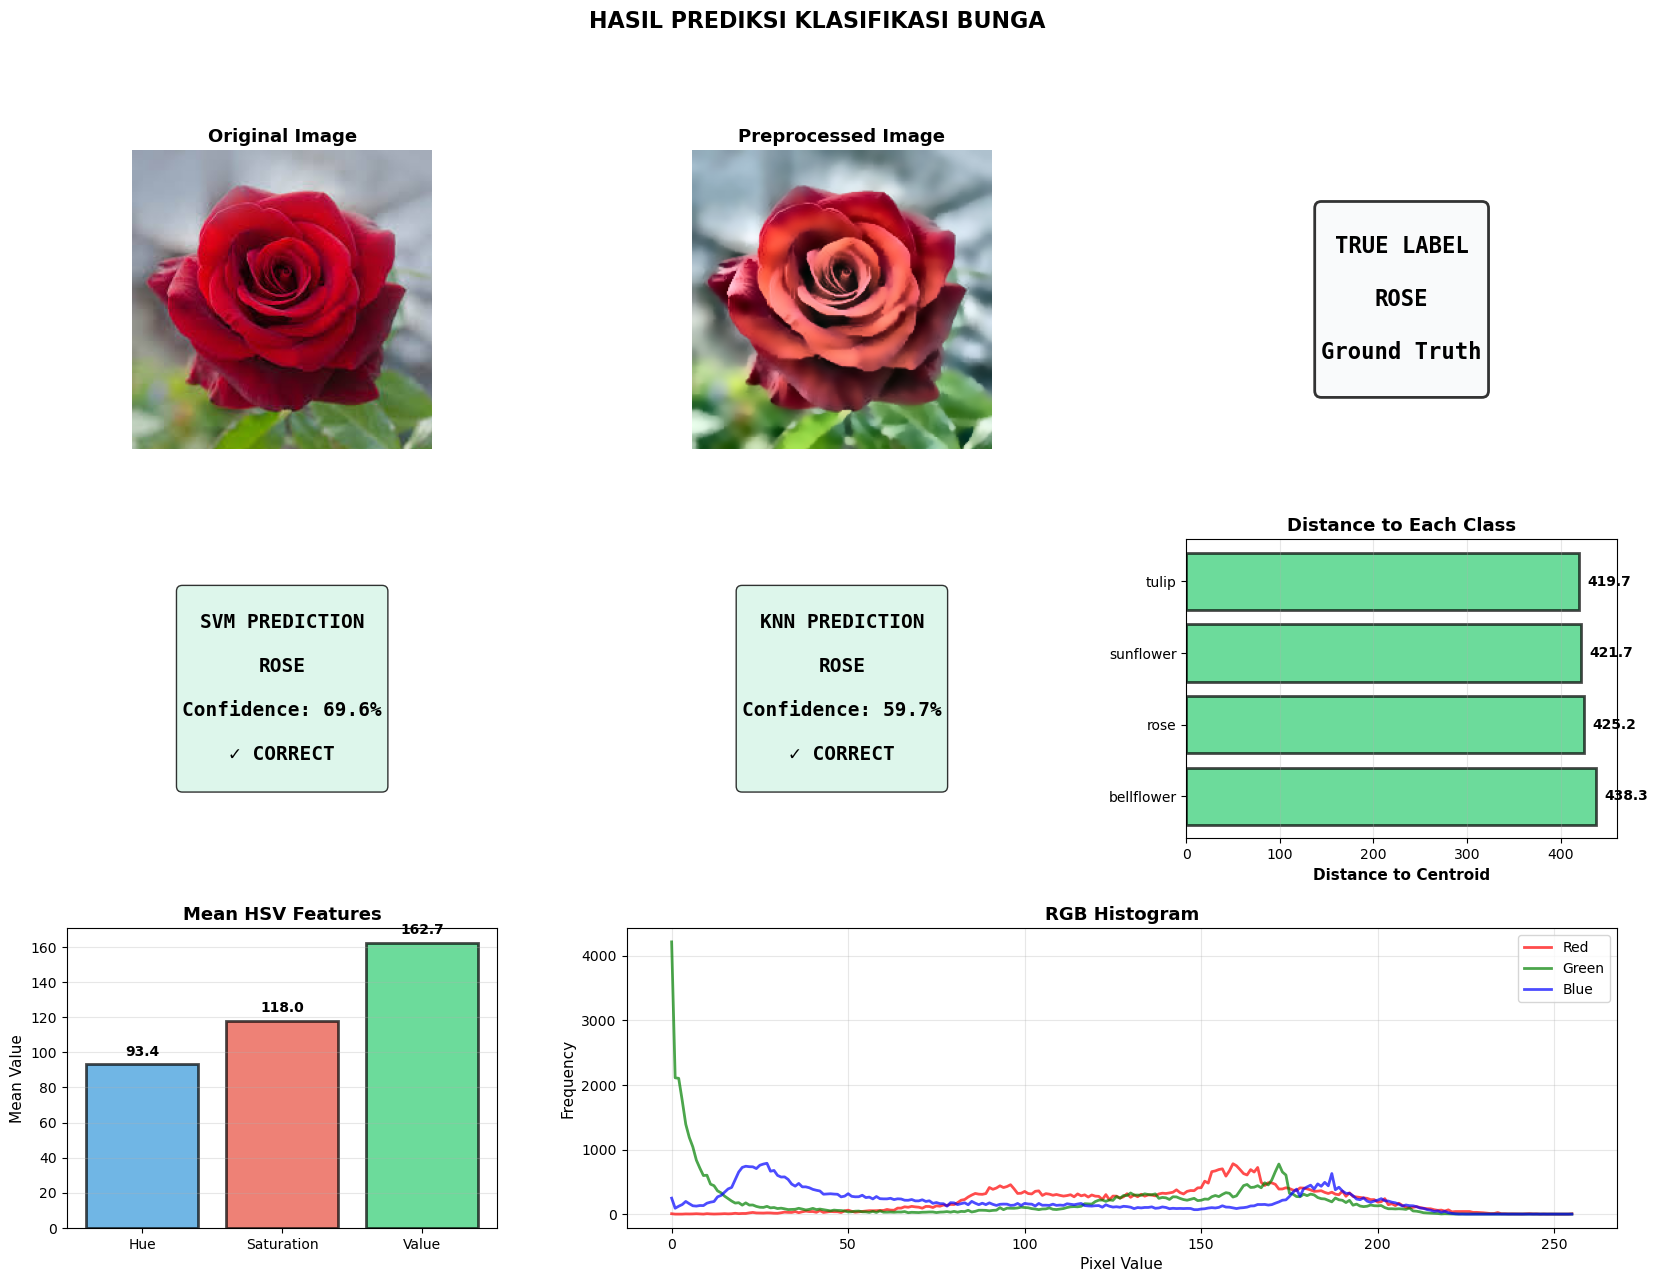


SUMMARY HASIL PREDIKSI
True Label       : ROSE
SVM Prediction   : ROSE (69.6%) - ✓ CORRECT
KNN Prediction   : ROSE (59.7%) - ✓ CORRECT
----------------------------------------------------------------------
Kedua model memprediksi dengan BENAR!
Winner: BOTH

MEMULAI PREDIKSI GAMBAR
Loading image: D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sunn.jpg
Gambar berhasil dimuat: (251, 201, 3)
Preprocessing gambar...
Ekstraksi fitur...
✓ Fitur berhasil diekstrak: 41 fitur
Menerapkan feature weighting...
Memeriksa apakah gambar termasuk dalam kelas yang dikenal...
Melakukan prediksi...
✓ Gambar teridentifikasi sebagai salah satu kelas yang dikenal
✓ Prediksi selesai!


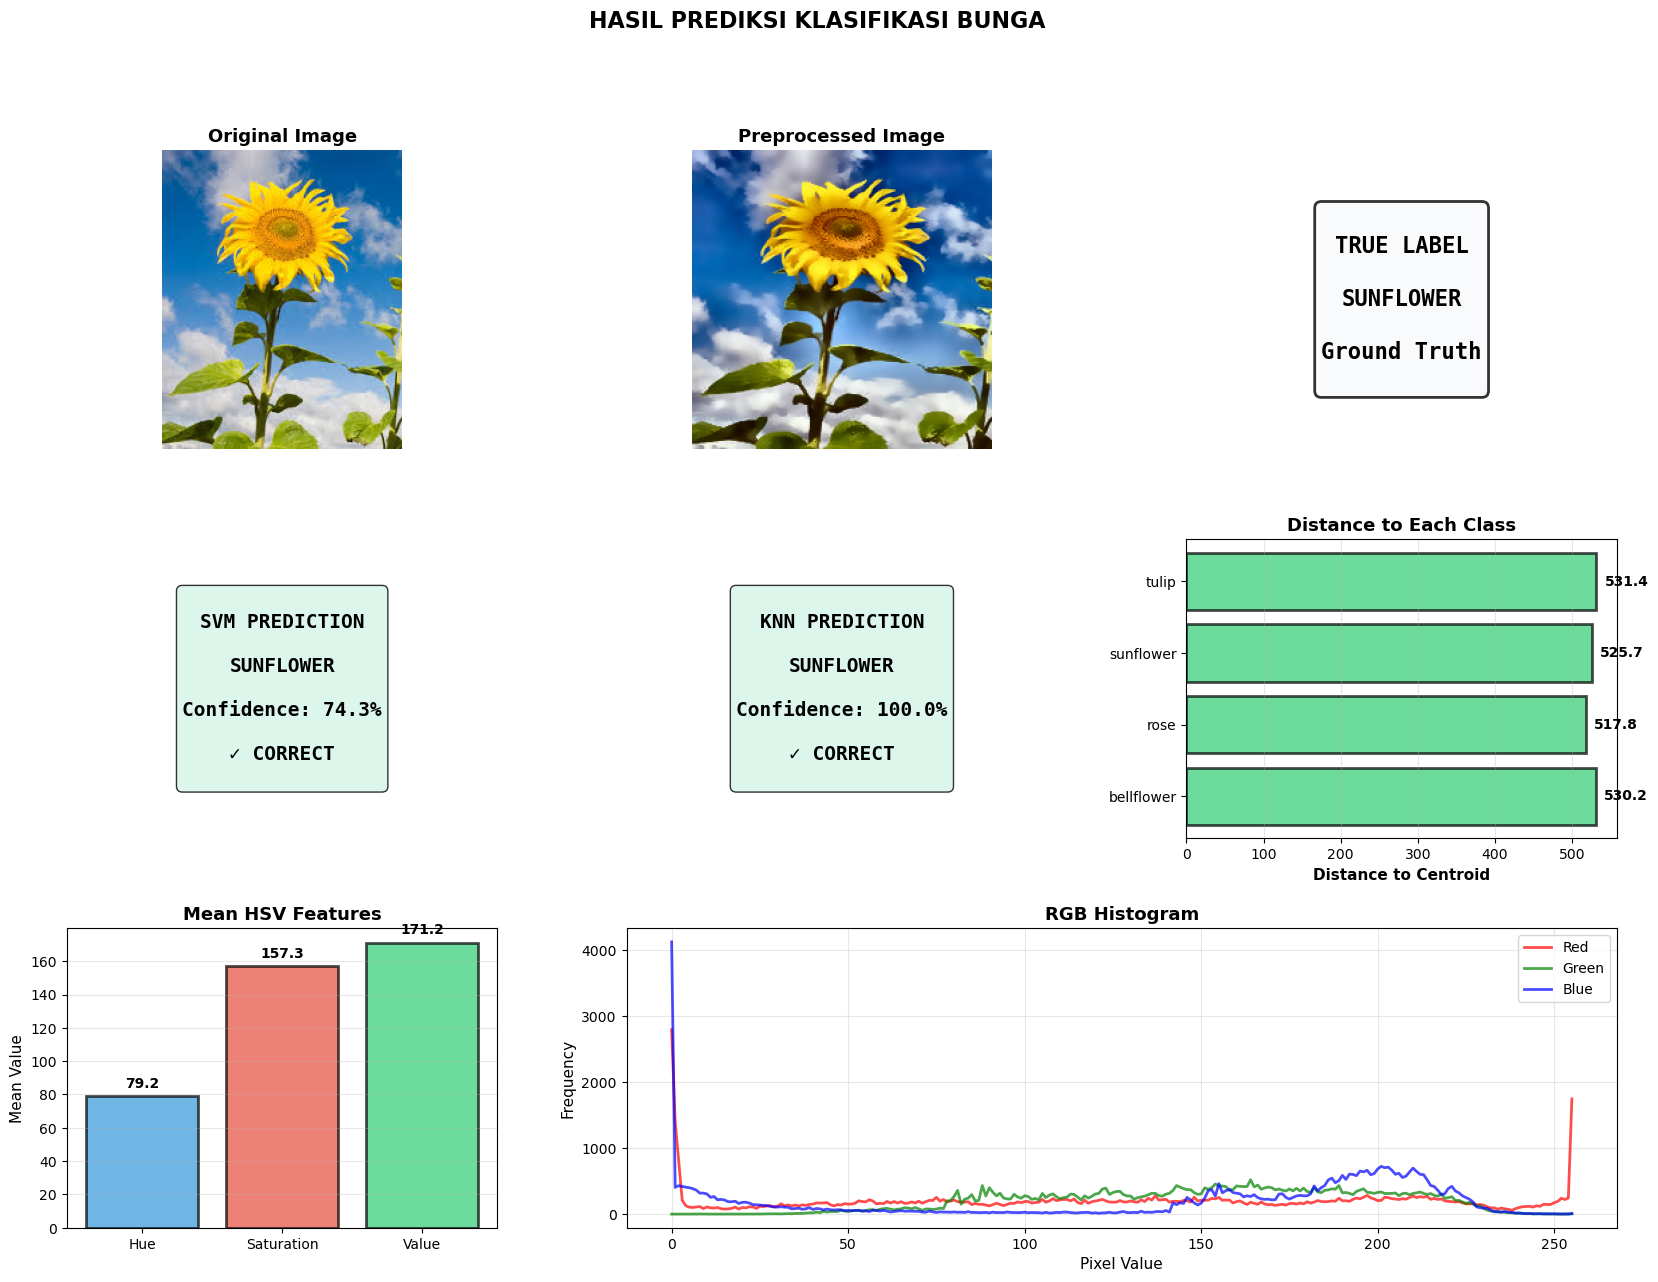


SUMMARY HASIL PREDIKSI
True Label       : SUNFLOWER
SVM Prediction   : SUNFLOWER (74.3%) - ✓ CORRECT
KNN Prediction   : SUNFLOWER (100.0%) - ✓ CORRECT
----------------------------------------------------------------------
Kedua model memprediksi dengan BENAR!
Winner: BOTH

MEMULAI PREDIKSI GAMBAR
Loading image: D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sapi.jpg
Gambar berhasil dimuat: (186, 271, 3)
Preprocessing gambar...
Ekstraksi fitur...
✓ Fitur berhasil diekstrak: 41 fitur
Menerapkan feature weighting...
Memeriksa apakah gambar termasuk dalam kelas yang dikenal...
Melakukan prediksi...

🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 
⚠️  GAMBAR DITOLAK - BUKAN DARI KELAS YANG DIKENAL
🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 🚫 

Alasan penolakan:
  1. Low confidence (SVM: 76.9%, KNN: 46.1%)

Jarak ke centroid setiap kelas:
  - TULIP       : 381.1
  - BELLFLOWER  : 386.7
  - SUNFLOWER   : 395.7
  - ROSE        : 397.9

  

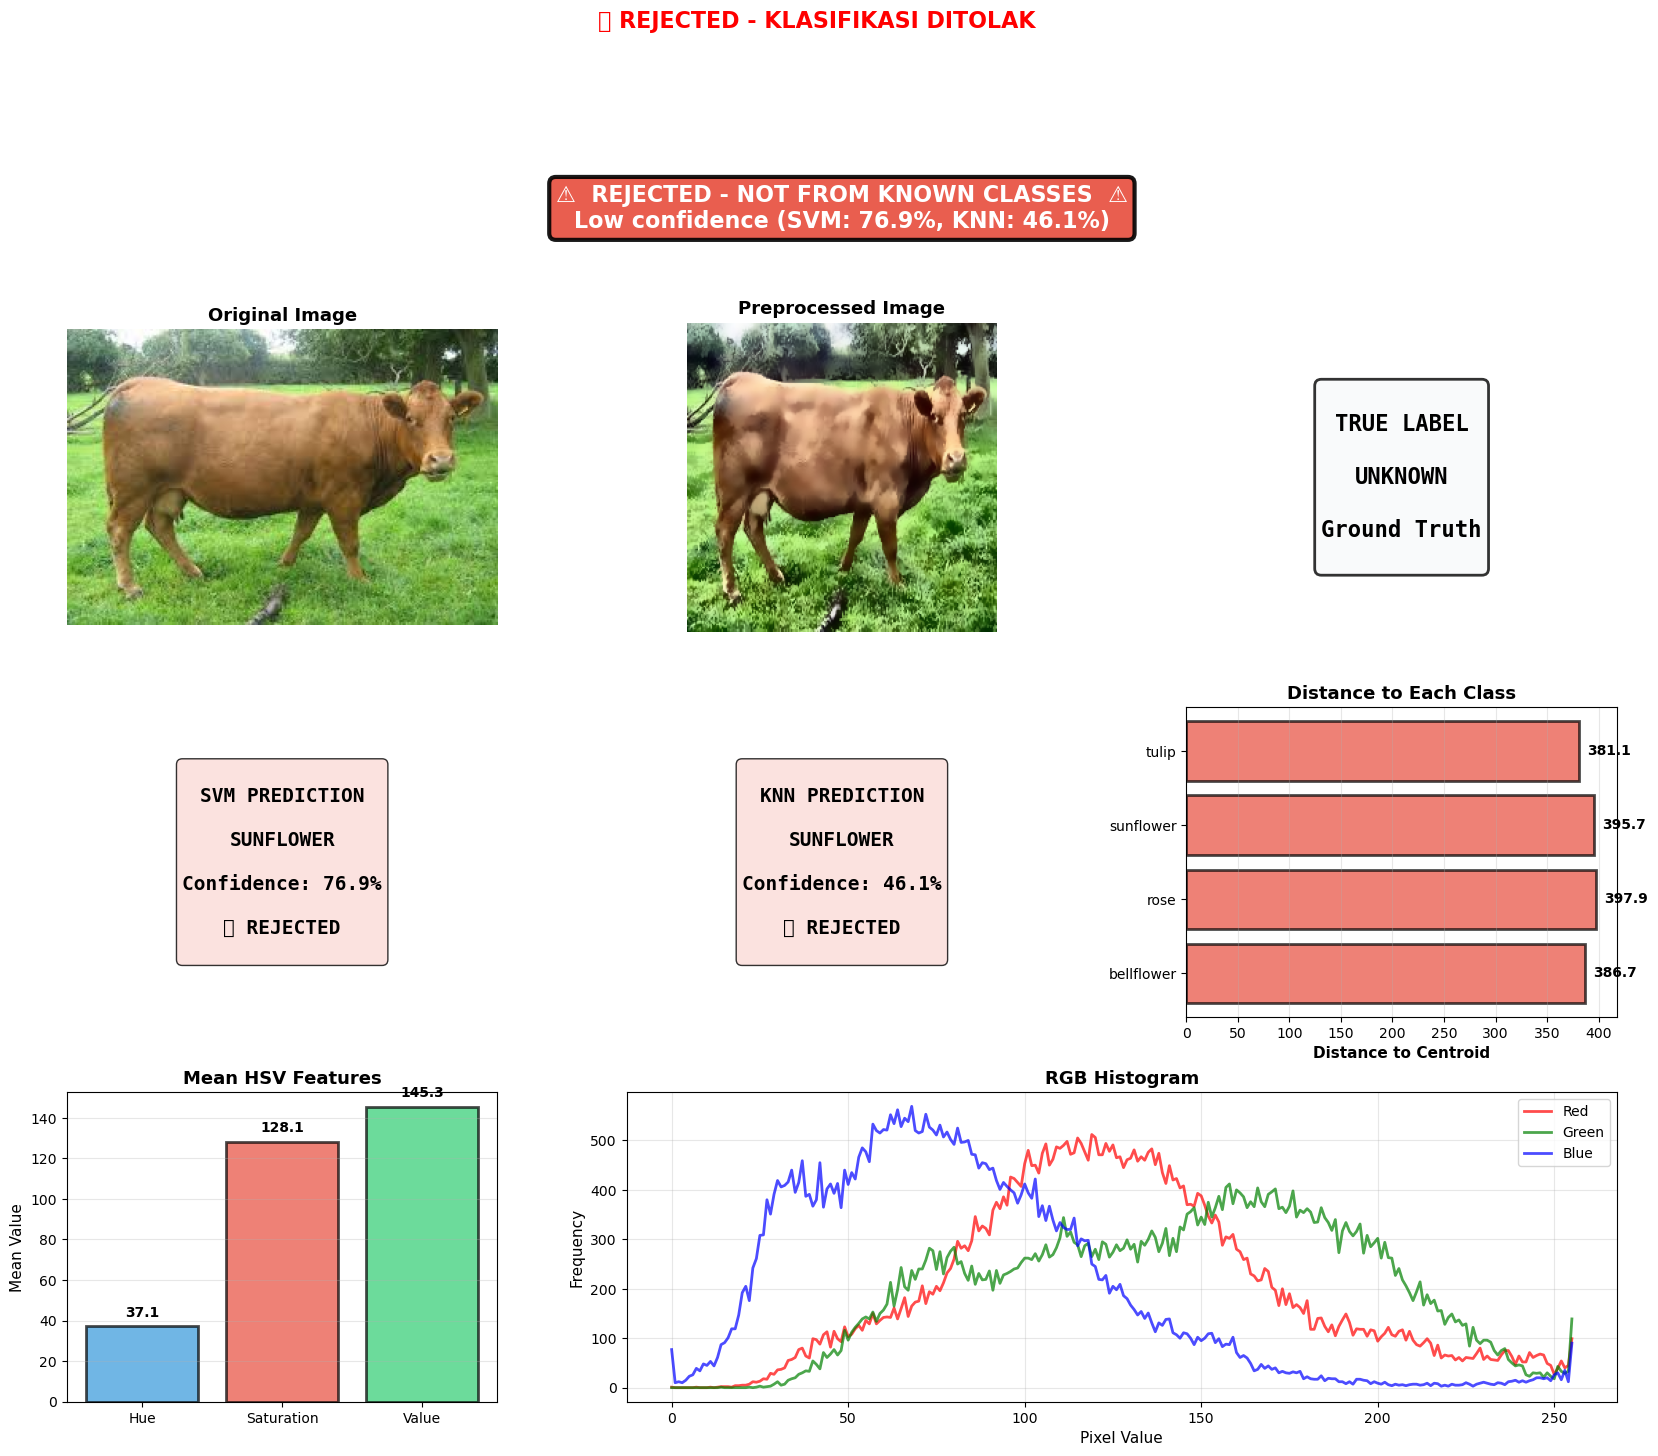


SUMMARY HASIL PREDIKSI
🚫 STATUS: REJECTED - Bukan dari kelas yang dikenal
True Label       : UNKNOWN
SVM Prediction   : SUNFLOWER (76.9%) - 🚫 REJECTED
KNN Prediction   : SUNFLOWER (46.1%) - 🚫 REJECTED
----------------------------------------------------------------------

Gambar ini TIDAK termasuk dalam kelas:
  • Bellflower  • Rose  • Sunflower  • Tulip

Prediksi model diabaikan karena confidence rendah
atau fitur terlalu berbeda dari training data.

MEMULAI PREDIKSI GAMBAR
Loading image: D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sunflow.jpg
Gambar berhasil dimuat: (183, 275, 3)
Preprocessing gambar...
Ekstraksi fitur...
✓ Fitur berhasil diekstrak: 41 fitur
Menerapkan feature weighting...
Memeriksa apakah gambar termasuk dalam kelas yang dikenal...
Melakukan prediksi...
✓ Gambar teridentifikasi sebagai salah satu kelas yang dikenal
✓ Prediksi selesai!


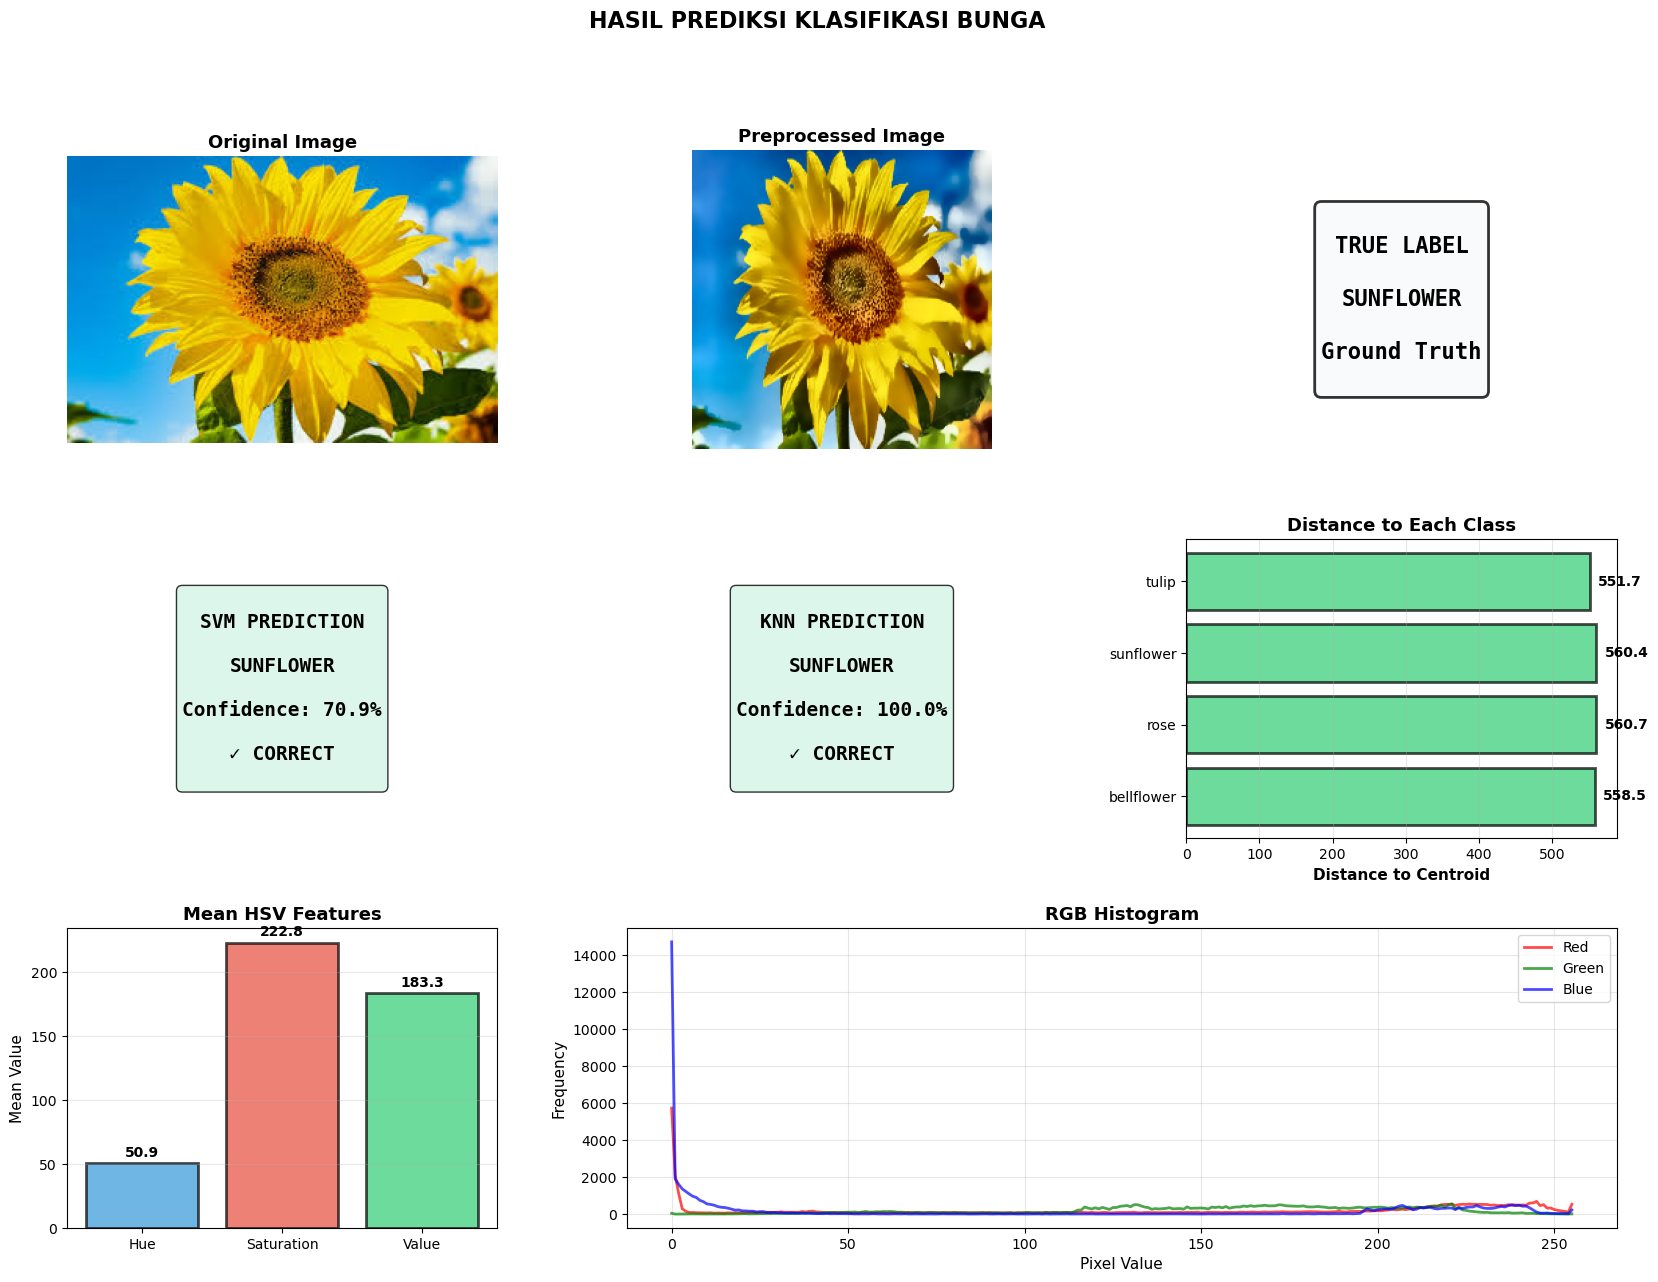


SUMMARY HASIL PREDIKSI
True Label       : SUNFLOWER
SVM Prediction   : SUNFLOWER (70.9%) - ✓ CORRECT
KNN Prediction   : SUNFLOWER (100.0%) - ✓ CORRECT
----------------------------------------------------------------------
Kedua model memprediksi dengan BENAR!
Winner: BOTH


In [37]:
# Contoh 1: Prediksi Rose
demo_path = r"D:\Code\ML-Kuliah\Project-Bunga\flower_classification\cobaaaaa.jpg"
result = predict_single_image(demo_path, true_label='rose')

# Contoh 2: Prediksi Sunflower
demo_path = r"D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sunn.jpg"
result = predict_single_image(demo_path, true_label='sunflower')

# Contoh 3: Prediksi Gambar BUKAN Bunga (sapi) 
demo_path = r"D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sapi.jpg"
result = predict_single_image(demo_path, true_label='unknown')  

# Contoh 1: Prediksi Rose
demo_path = r"D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sunflow.jpg"
result = predict_single_image(demo_path, true_label='sunflower')

### Coba Integrasi Flutter

In [33]:
import pickle
import os

# Buat folder untuk menyimpan model
model_dir = "model_api"
os.makedirs(model_dir, exist_ok=True)

print("="*70)
print("SAVING MODEL DAN DEPENDENCIES UNTUK API")
print("="*70)

# 1. Simpan SVM Model (model terbaik)
with open(f'{model_dir}/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("✓ SVM Model disimpan: model_api/svm_model.pkl")

# 2. Simpan KNN Model
with open(f'{model_dir}/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
print("✓ KNN Model disimpan: model_api/knn_model.pkl")

# 3. Simpan Scaler
with open(f'{model_dir}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler disimpan: model_api/scaler.pkl")

# 4. Simpan Label Encoder
with open(f'{model_dir}/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("✓ Label Encoder disimpan: model_api/label_encoder.pkl")

# 5. Simpan Feature Weights
with open(f'{model_dir}/feature_weights.pkl', 'wb') as f:
    pickle.dump(feature_weights, f)
print("✓ Feature Weights disimpan: model_api/feature_weights.pkl")

# 6. Simpan Centroid untuk Manhattan Distance
with open(f'{model_dir}/class_centroids.pkl', 'wb') as f:
    pickle.dump(class_centroids, f)
print("✓ Class Centroids disimpan: model_api/class_centroids.pkl")

print("\n" + "="*70)
print("SEMUA MODEL BERHASIL DISIMPAN!")
print("="*70)
print(f"\nFile yang tersimpan di folder '{model_dir}/':")
print("  1. svm_model.pkl         → Model SVM")
print("  2. knn_model.pkl         → Model KNN")
print("  3. scaler.pkl            → StandardScaler")
print("  4. label_encoder.pkl     → LabelEncoder")
print("  5. feature_weights.pkl   → Bobot fitur")
print("  6. class_centroids.pkl   → Centroid Manhattan Distance")
print("\n✓ Siap untuk digunakan di Flask API!")

SAVING MODEL DAN DEPENDENCIES UNTUK API
✓ SVM Model disimpan: model_api/svm_model.pkl
✓ KNN Model disimpan: model_api/knn_model.pkl
✓ Scaler disimpan: model_api/scaler.pkl
✓ Label Encoder disimpan: model_api/label_encoder.pkl
✓ Feature Weights disimpan: model_api/feature_weights.pkl
✓ Class Centroids disimpan: model_api/class_centroids.pkl

SEMUA MODEL BERHASIL DISIMPAN!

File yang tersimpan di folder 'model_api/':
  1. svm_model.pkl         → Model SVM
  2. knn_model.pkl         → Model KNN
  3. scaler.pkl            → StandardScaler
  4. label_encoder.pkl     → LabelEncoder
  5. feature_weights.pkl   → Bobot fitur
  6. class_centroids.pkl   → Centroid Manhattan Distance

✓ Siap untuk digunakan di Flask API!


#### 📱 Cara Menghubungkan dengan Flutter Mobile

File-file yang sudah dibuat:
1. **`app.py`** - Flask API server
2. **`requirements.txt`** - Dependencies Python
3. **`API_DOCUMENTATION.md`** - Dokumentasi lengkap

#### Langkah-langkah:

**1. Install Dependencies:**
```bash
pip install -r requirements.txt
```

**2. Jalankan API Server:**
```bash
python app.py
```
Server akan running di `http://0.0.0.0:5000`

**3. Cek IP Address Komputer:**
```bash
# Windows
ipconfig

# Cari IPv4 Address (contoh: 192.168.1.100)
```

**4. Di Flutter, panggil API:**
```dart
// Ganti dengan IP komputer Anda
final url = 'http://192.168.1.100:5000/predict';

var request = http.MultipartRequest('POST', Uri.parse(url));
request.files.add(await http.MultipartFile.fromPath('image', imagePath));

var response = await request.send();
var responseData = await response.stream.bytesToString();
var result = json.decode(responseData);

// Result berisi:
// - prediction_svm
// - prediction_knn  
// - prediction_manhattan
// - confidence_svm
// - confidence_knn
```

**📖 Baca `API_DOCUMENTATION.md` untuk:**
- Contoh code Flutter lengkap
- Endpoint API details
- Troubleshooting
- Testing dengan Postman/cURL

#### 🧪 Testing API (Before Connect to Flutter)

Sebelum menghubungkan dengan Flutter, test dulu API-nya berfungsi dengan baik:

#### **Method 1: Using Browser (Health Check)**
```
http://localhost:5000/health
```

#### **Method 2: Using Python requests**
Jalankan cell di bawah ini setelah API server running!

In [34]:
import requests
import json

# ===== TEST 1: Health Check =====
print("="*70)
print("TEST 1: Health Check API")
print("="*70)

try:
    response = requests.get('http://localhost:5000/health', timeout=5)
    if response.status_code == 200:
        print("✓ API is running!")
        print(json.dumps(response.json(), indent=2))
    else:
        print(f"✗ Error: Status code {response.status_code}")
except requests.exceptions.ConnectionError:
    print("✗ API tidak berjalan!")
    print("   Jalankan: python app.py")
except Exception as e:
    print(f"✗ Error: {e}")

print("\n" + "="*70)
print("TEST 2: Predict Image")
print("="*70)

# Pilih gambar dari validation set
test_image = r'D:\Code\ML-Kuliah\Project-Bunga\flower_classification\sunn.jpg'

try:
    # Upload image ke API
    with open(test_image, 'rb') as f:
        files = {'image': f}
        response = requests.post('http://localhost:5000/predict', files=files, timeout=30)
    
    if response.status_code == 200:
        result = response.json()
        print("✓ Prediction successful!")
        print(f"\nSVM Prediction:       {result['prediction_svm']} ({result['confidence_svm']:.1f}%)")
        print(f"KNN Prediction:       {result['prediction_knn']} ({result['confidence_knn']:.1f}%)")
        print(f"Manhattan Prediction: {result['prediction_manhattan']}")
        
        print("\nManhattan Distances:")
        for class_name, dist in result['distances_manhattan'].items():
            print(f"  {class_name:12} → {dist:.2f}")
    else:
        print(f"✗ Error: {response.status_code}")
        print(response.text)
        
except requests.exceptions.ConnectionError:
    print("✗ API tidak berjalan!")
except FileNotFoundError:
    print(f"✗ Image file not found: {test_image}")
except Exception as e:
    print(f"✗ Error: {e}")

print("\n" + "="*70)
print("✓ API Testing Complete")
print("="*70)
print("\nJika semua test berhasil, API siap digunakan di Flutter!")

TEST 1: Health Check API
✗ API tidak berjalan!
   Jalankan: python app.py

TEST 2: Predict Image
✗ API tidak berjalan!
   Jalankan: python app.py

TEST 2: Predict Image
✗ API tidak berjalan!

✓ API Testing Complete

Jika semua test berhasil, API siap digunakan di Flutter!
✗ API tidak berjalan!

✓ API Testing Complete

Jika semua test berhasil, API siap digunakan di Flutter!
